<a href="https://colab.research.google.com/github/meysamvarasteh92/meysamvarasteh/blob/main/adults_CF_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness Auditing through the lens of Counterfactual Explanations

This is the source code for the experiments performed in the paper titled **"Fairness Auditing through the lens of Counterfactual Explanations"** submitted to **IP&M**. This work was done by *Yashar Deldjoo, Meysam Varasteh, Yara Mohammadi Bahram, Marco Antonio Insabato, and Tommaso Di Noia*. 

Note that this notebook is only an initial demonstration and is not indicative of all of the experiements performed.

## Start from Scratch

### Import libraries

matplotlib v3.4 is needed

In [45]:
pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
!pip install dice-ml
import dice_ml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KernelDensity
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from scipy.interpolate import make_interp_spline
from matplotlib.patches import Patch
from matplotlib import cm
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Data loading and preprocessing

We use the Adults dataset here. We make every feature categorical. 

In [70]:
features_unique={'age': 'continuous',
'workclass': ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],
'fnlwgt': 'continuous', #weight for how many people belong to that class in the individual states
'education': ['Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters', '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool'],
'education-num': 'continuous',
'marital-status': ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],
'occupation': ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],
'relationship': ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'],
'race': ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],
'sex': ['Female', 'Male'],
'capital-gain': 'continuous',
'capital-loss': 'continuous',
'hours_per_week': 'continuous',
'native_country': ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands'],
'result': ['>50K', '<=50K']}

features_categorical=[] #initialize empty categorical feature values
features_numerical=[] #initialize empty numerical feature values
for key in features_unique:
  if features_unique[key] != 'continuous':
    features_categorical.append(key)
  elif key != 'education-num' and key != 'fnlwgt':
    features_numerical.append(key)
  
features_categorical[:-1]
features_categorical_s=['sex','race','native_country']  #Sensitive features
#features_categorical_s=['native-country']  #Sensitive features

features_categorical_ns=list(set(features_categorical[:-1])-set(features_categorical_s))   #nonsensitive features

In [71]:
adults_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',sep=',',header=None)

adults_df.columns = list(features_unique.keys())
#display(adults_df)

adults_df=adults_df.drop(['fnlwgt','education-num'],axis=1) #fnlwgt is useless,

for feature in features_categorical:
  adults_df.replace([' '+string for string in features_unique[feature]],features_unique[feature],inplace=True)

adults_df.loc[adults_df.result.str.contains("<=50K")==True,'result']= False
adults_df.loc[adults_df.result.str.contains(">50K")==True,'result']= True
adults_df.loc[(adults_df.relationship == 'Husband') | (adults_df.relationship == 'Wife'),'relationship'] = ' Married'
adults_df=adults_df.drop(adults_df.loc[adults_df.native_country=="Holand-Netherlands"].index.values)

def agebrackets(age):
  if age<24:
    age_range = '18-24'
  elif age<40:
    age_range = '25-40'
  elif age<60:
    age_range = '41-60'
  else:
    age_range = '>60'
  return age_range
adults_df.age = adults_df.age.apply(agebrackets)

adults_df_trial=adults_df.replace(to_replace=' ?', value=np.nan,inplace=True)
adults_df_trial=adults_df.dropna()
adults_df=adults_df.dropna()

In [72]:
def hours_per_week_brackets(hours):
  if hours<20:
    hours_range = '0-20'
  elif hours<30:
    hours_range = '21-30'
  elif hours<40:
    hours_range = '31-40'
  elif hours<50:
    hours_range = '41-50'
  else:
    hours_range = '>50'
  return hours_range

adults_df.hours_per_week = adults_df.hours_per_week.apply(hours_per_week_brackets)

In [73]:
features_categorical_ns.append('hours_per_week')

In [74]:
# Split the train and test datasets
target = adults_df.result
train_dataset, test_dataset, y_train, y_test = sklearn.model_selection.train_test_split(adults_df,target,test_size=0.2,random_state=0,stratify=target)
All_Datasets={'train_dataset':train_dataset,'test_dataset':test_dataset,'y_train':y_train,'y_test':y_test}

train_dataset, test_dataset, y_train, y_test = All_Datasets['train_dataset'], All_Datasets['test_dataset'], All_Datasets['y_train'], All_Datasets['y_test']
y_train = train_dataset['result'].reset_index(drop=True) 
x_train = train_dataset.drop(['result'], axis=1)
y_test = test_dataset['result'].reset_index(drop=True) 
x_test = test_dataset.drop(['result'], axis=1)
x_test = x_test.reset_index(drop=True)

### Save and Load dataset

In [ ]:
'''
#target = adults_df.result
#train_dataset, test_dataset, y_train, y_test = sklearn.model_selection.train_test_split(adults_df,target,test_size=0.2,random_state=0,stratify=target)
All_Datasets={'train_dataset':train_dataset,'test_dataset':test_dataset,'y_train':y_train,'y_test':y_test}
path='/content/drive/My Drive/DATASET/All_Datasets.pkl'
with open(path, 'wb') as f:
    pickle.dump(All_Datasets, f)
'''

In [ ]:
'''
import pickle
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/DATASET/All_Datasets.pkl'
with open(path, 'rb') as f:
    All_Datasets=pickle.load(f)
'''

Mounted at /content/drive


### Deriving Feature value importance scores

In the table, we can see the normalized value importances for each feature value. Each value from 1 to 10 describes the importance of a feature towards obtaining the desired outcome based on the ground truth values in the training dataset. This value is derived based on how likely having each feature value helps achieving the desired label class in the training dataset.

In [75]:
effort_score = {} #education, marital status, workclass, occupation, relationship
dict_edu = {}
def effort_dict(adults_df,col):
  val_50K=adults_df[adults_df.result==1].groupby(col).result.describe()['count'].rename('o', inplace=True).apply(int)
  #print("val_50k:", val_50K)
  val_tot=adults_df.groupby(col).result.describe()['count'].rename('o', inplace=True).apply(int)
  #print("val_tot:",val_tot)
  ratio = (val_50K/val_tot).sort_values(ascending=False)
  #effort_wc=np.round(max_score*ratio/ratio[0],2)
  return ratio


effort_score ={effort_col : effort_dict(train_dataset,effort_col) for effort_col in features_categorical_ns}
#display(effort_score)


best = 0
for effort_col in features_categorical_ns:
  best = max(best,effort_score[effort_col][0])
  #print(effort_score[effort_col][0])
  #print('best:',best)

for effort_col in features_categorical_ns:
  effort_score[effort_col] = effort_score[effort_col]/best*10
  #print('effort_score:',effort_score )
#this step is removed because it is methodologically inconsistent with how scores are otherwise calculated
#for edu_num,edu in zip (adults_df['education'].unique(),adults_df['education-num'].unique()):
#print(f'{edu_num}\t{edu}')
#dict_edu[edu] = edu_num
#effort_score['education'] = dict_edu

score_dataframe={}
df_styler={}
for col in features_categorical_ns:
  score_dataframe[col]=pd.DataFrame.from_dict(effort_score[col])
  score_dataframe[col].columns=['']
  #print('score_dataframe',score_dataframe['marital-status'])
  df_styler[col] = score_dataframe[col].style.set_table_attributes("style='display:inline'").set_caption(col)
display_html(df_styler['education']._repr_html_()+df_styler['occupation']._repr_html_()+df_styler['workclass']._repr_html_()+df_styler['marital-status']._repr_html_()+df_styler['relationship']._repr_html_()+df_styler['hours_per_week']._repr_html_(),raw=True)

,
education,
Doctorate,10.000000
Prof-school,9.913579
Masters,7.433395
Bachelors,5.530931
Assoc-voc,3.495616
Assoc-acdm,3.335537
Some-college,2.747430
HS-grad,2.141406
12th,1.064181


### Sum of scores (Deriving the Qualification socres, skip this for now)

In [ ]:
'''
tmp = pd.Series([0 for _ in range(len(adults_df))], index = adults_df.index)
for f in features_categorical_ns:
  tmp = tmp.add(adults_df[f].apply(lambda x: float(score_dataframe[f].loc[x])), fill_value=0)
adults_df['Sum_of_Score']=tmp
'''

In [ ]:
'''
def Sum_Of_Score(score):
   if score<10:
    score_range = '0-10'
   elif score<15:
    score_range = '11-15'
   elif score<20:
    score_range = '16-20'
   elif score<25:
    score_range = '21-25'
   elif score<30:
    score_range = '26-30'
   else:
    score_range = '>30'
   return score_range
adults_df['Sum_of_Score_g'] = adults_df.Sum_of_Score.apply(Sum_Of_Score)

display(adults_df)
'''

### Baseline Models (Random and Majority Classifier)

These two classifiers are used as baselines. Random classifier treats every sensitive group similarly, requiring a random effort from each candidate for overturning the classifier's prediction. The Majority classifier, favors the majority groups of each sensitive class (Like males, whites) over the minorities based on their qualification values. For example, it requires less qualification for men than woman in order to be accepted.

In [76]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
import random

class RandomClassifier(BaseEstimator, ClassifierMixin):
    np.random.seed(0)

    def __init__(self):
        pass

    def fit(self, X, y=None):
        pass
    
    def predict(self, X, y=None):
        return np.random.randint(2, size=X.shape[0])
    
    def predict_proba(self, X, y=None):
        out = np.random.randint(2, size=X.shape[0])
        proba = [[[1, 0], [0, 1]][i] for i in out]
        return np.array(proba)
        
        
r = RandomClassifier()
r.fit(np.array([1,2,3,4,5]), np.array([0, 0, 1, 1, 1]))
print(r.predict(np.array([1, 2, 3, 4, 5])))


class MajorityClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, majority_feature='sex', majority_value='male', qual = False):
        self.majority_feature = majority_feature
        self.majority_value = majority_value
        self.targets = [0, 1]
        self.qual = qual

    def fit(self, X, y=None):
        pass
    
    def qual_weight(self, qual_v, base):
        
        return int(qual_v < base), int(qual_v >= base)
    
    def get_qualification(self, X):
        tmp = pd.Series([0 for _ in range(len(X))], index = X.index)
        for f in features_categorical_ns:
          tmp = tmp.add(X[f].apply(lambda x: float(score_dataframe[f].loc[x])), fill_value=0)
        return tmp
    
    def predict(self, X, y=None):
        
        # Measure qualification again
        X.loc[:, 'Sum_of_Score'] = self.get_qualification(X) 
        
        if self.qual:
            predict = X[[self.majority_feature]].apply(lambda x: self.qual_weight(X['Sum_of_Score'][x.name], 15) if x[0]==self.majority_value else list(self.qual_weight(X['Sum_of_Score'][x.name], 20)), axis = 1)
            predict = predict.apply(lambda x: np.argmax(x))
        else:
            predict = X[self.majority_feature].apply(lambda x: random.choices(self.targets, weights=(20, 80), k=1)[0] if x==self.majority_value else random.choices(self.targets, weights=(80, 20), k=1)[0])
        return predict.to_numpy()
    
    def predict_proba(self, X, y=None):
        
        # Measure qualification again
        X.loc[:, 'Sum_of_Score'] = self.get_qualification(X) 
        
        if self.qual:
            proba = X[[self.majority_feature]].apply(lambda x: list(self.qual_weight(X['Sum_of_Score'][x.name], 15)) if x[0]==self.majority_value else list(self.qual_weight(X['Sum_of_Score'][x.name], 20)), axis = 1)
            proba = list(map(list, proba))
        else:
            predict = X[self.majority_feature].apply(lambda x: random.choices(self.targets, weights=(20, 80), k=1)[0] if x==self.majority_value else random.choices(self.targets, weights=(80, 20), k=1)[0])
            proba = [[[1, 0], [0, 1]][i] for i in predict]
        return np.array(proba)
        

#r = MajorityClassifier(majority_feature='Sex', majority_value='Male')
#r.fit(pd.DataFrame({'Sex': ['Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male']}), np.array([0, 0, 1, 1, 1, 1, 1]))
#print(r.predict(pd.DataFrame({'Sex': ['Male', 'Male', 'Male', 'Male', 'Male', 'Male', 'Male']})))


[0 1 1 0 1]


### Train models

The models used here are off-the-shelf classifiers in SKlearn, as well as the baseline classifiers Random, Majority Male, and Majority White.

In [77]:

algnames = ['Random Forest',
            'Decision Tree',
            'K-Nearest Neighbor',
            'Neural Net',
            'SVM',
            'Adaboost',
            'Random', 
            'Majority Male', 
            #'Majority White' # In this notebook, we only analyze sex and not race
            ]

algos = [RandomForestClassifier(n_jobs=2),
         DecisionTreeClassifier(),
         KNeighborsClassifier(),
         MLPClassifier(alpha=1, max_iter=1000),
         svm.SVC(probability=True),
         AdaBoostClassifier(),
         RandomClassifier(), 
         MajorityClassifier(majority_feature='sex', majority_value='Male', qual = True), 
         # MajorityClassifier(majority_feature='race', majority_value='White', qual = True)
]

# algnames=['Majority Male', 
#            'Majority White']
# algos=[MajorityClassifier(majority_feature='sex', majority_value='Male', qual = True), 
#         MajorityClassifier(majority_feature='race', majority_value='White', qual = True)    ]        

Here the preprocess + fitting pipeline is created for training the models, as well as a DICE instance for each classifier. 

Our method can be used with any form of counterfactual explanations and we use DICE for demonstration purposes here. DICE provides actionable and feasible counterfactual explanations, and it can provide a number of counterfactual explanations for each instance. 

In [78]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
transformations = ColumnTransformer(transformers=[('cat', categorical_transformer, features_categorical[:-1])])

def GeneratePipeline(classifier, name, transformations):
    
  print(name)
  # Baseline classifiers dont need require preprocessing as they only work based 
  # on sensitive attributes and qualification values
  if name in ['Random', 'Majority Male', 'Majority White']: 
    clf = Pipeline(steps=[('classifier', classifier)])
    
  else:
      clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', classifier)])
  return clf

def TrainModels(x,y,clf):
  model=clf.fit(x, y.astype('int'))
  dice_model = dice_ml.Model(model=model, backend="sklearn")
  return model,dice_model

clf_dict = {}
model = {}
dice_model = {}

for classifier,name in zip(algos,algnames):
  clf_dict[name] = GeneratePipeline(classifier, name, transformations)
  # Remove the ".iloc[:10000]" for a full run
  model[name],dice_model[name] = TrainModels(x_train.iloc[:10000],y_train.iloc[:10000],clf_dict[name])

Random Forest
Decision Tree
K-Nearest Neighbor
Neural Net
SVM
Adaboost
Random
Majority Male


### Setting up DICE

We create a dictionary containing the DICE models to generate the counterfactuals

In [79]:
d = dice_ml.Data(dataframe=train_dataset, continuous_features=['capital-loss', 'capital-gain'], outcome_name='result')
exp = {} 
y_out = {}
for name in algnames:
  exp[name] = dice_ml.Dice(d, dice_model[name])
  y_out[name] = pd.Series(clf_dict[name].predict(x_test)).apply(int).sort_index()

### Prepare all negatively predicted samples in the test dataset for each algoithm

Since we want to assess fairness for the adversely treated individuals, we pass the test dataset through each classifier, only saving the samples with negative predictions to represent the auditing population for each classifier.





In [80]:
negative_test_x = {name : pd.DataFrame() for name in algnames}
negative_test_y = {name : pd.Series() for name in algnames}

for name in algnames:
    negative_test_x[name] = x_test[y_out[name].apply(int) == 0]
    negative_test_y[name] = y_test[y_out[name].apply(int) == 0]
    print(name, " has ", len(negative_test_y[name]))

Random Forest  has  4824
Decision Tree  has  4848
K-Nearest Neighbor  has  4787
Neural Net  has  4905
SVM  has  4984
Adaboost  has  4902
Random  has  3055
Majority Male  has  2514


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
'''
for name in algnames:
  for sex in ["Male","Female"]:
      samp=negative_test_x[name][negative_test_x[name].sex==sex].Sum_of_Score.mean()
      print(name,sex,samp)
'''

Majority Male Male 11.515905983285597
Majority Male Female 15.151811245748732
Majority White Male 13.709122146549868
Majority White Female 12.145418172939209


### Accuracy

Here we report the accuracy of each classifier (Can be skipped)

In [81]:
for name in algnames:
  acc = sklearn.metrics.accuracy_score(y_test.apply(int), y_out[name].apply(int))
  print(f'The accuracy for {name} is {acc*100:.1f}%')

The accuracy for Random Forest is 81.3%
The accuracy for Decision Tree is 80.3%
The accuracy for K-Nearest Neighbor is 81.2%
The accuracy for Neural Net is 82.8%
The accuracy for SVM is 82.7%
The accuracy for Adaboost is 82.6%
The accuracy for Random is 50.2%
The accuracy for Majority Male is 64.6%


### Generating and saving Counterfactual Explanations 
We generate up to 5 counterfactual explanations for the adversely treated samples of each classifier by allowing DICE to change the non-sensitive categorical features which are actionable and feasible.

In [82]:
features_categorical_ns = ['workclass', 'occupation', 'education', 'hours_per_week']

In [83]:
import pickle

from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Fainess_CE/publish_adult.pkl'

with open(path, 'wb') as f:
  
  counterfactuals_exp_o = {}
  for name in algnames:
      print(name) 
      # For ease of running, only 10 samples are selected from each population. 
      # For a full run, remove the ".iloc[0:200]" part
      counterfactuals_exp_o[name]=exp[name].generate_counterfactuals(negative_test_x[name].iloc[0:500].drop(['Sum_of_Score'],axis=1), total_CFs=5,desired_class=1 ,features_to_vary=features_categorical_ns)

      pickle.dump(counterfactuals_exp_o[name], f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Random Forest


  0%|          | 2/500 [00:02<12:09,  1.46s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  1%|          | 3/500 [00:03<09:00,  1.09s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  1%|          | 4/500 [00:04<07:29,  1.10it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  1%|          | 5/500 [00:05<08:18,  1.01s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  1%|          | 6/500 [00:06<07:14,  1.14it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  2%|▏         | 8/500 [00:08<09:17,  1.13s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  3%|▎         | 14/500 [00:17<10:16,  1.27s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  4%|▎         | 18/500 [00:23<09:59,  1.24s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  4%|▍         | 19/500 [00:23<08:30,  1.06s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  4%|▍         | 21/500 [00:26<10:09,  1.27s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  4%|▍         | 22/500 [00:27<08:39,  1.09s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  6%|▌         | 28/500 [00:36<10:33,  1.34s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  6%|▌         | 31/500 [00:40<10:16,  1.31s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  6%|▋         | 32/500 [00:41<10:24,  1.34s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  9%|▉         | 44/500 [01:01<11:29,  1.51s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  9%|▉         | 46/500 [01:03<09:36,  1.27s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 11%|█         | 54/500 [01:14<09:28,  1.27s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 11%|█         | 55/500 [01:15<08:00,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 12%|█▏        | 61/500 [01:24<09:15,  1.27s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 12%|█▏        | 62/500 [01:24<07:51,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 13%|█▎        | 66/500 [01:30<09:13,  1.28s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 14%|█▍        | 69/500 [01:34<08:34,  1.19s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 15%|█▌        | 75/500 [01:44<11:25,  1.61s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 15%|█▌        | 76/500 [01:45<09:20,  1.32s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 17%|█▋        | 85/500 [01:58<08:58,  1.30s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 17%|█▋        | 86/500 [01:59<07:34,  1.10s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 17%|█▋        | 87/500 [01:59<06:36,  1.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 18%|█▊        | 91/500 [02:06<09:12,  1.35s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 21%|██        | 105/500 [02:27<09:10,  1.39s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 21%|██▏       | 107/500 [02:30<08:58,  1.37s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 23%|██▎       | 114/500 [02:40<08:21,  1.30s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 23%|██▎       | 117/500 [02:44<07:39,  1.20s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 24%|██▎       | 118/500 [02:46<08:01,  1.26s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 25%|██▌       | 125/500 [02:57<09:21,  1.50s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 26%|██▋       | 132/500 [03:07<07:53,  1.29s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 27%|██▋       | 134/500 [03:09<07:02,  1.15s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 27%|██▋       | 135/500 [03:10<06:05,  1.00s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 29%|██▉       | 147/500 [03:28<08:41,  1.48s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 30%|███       | 150/500 [03:32<07:21,  1.26s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 30%|███       | 152/500 [03:35<08:06,  1.40s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 31%|███       | 155/500 [03:39<07:17,  1.27s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 31%|███▏      | 157/500 [03:42<07:06,  1.24s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 32%|███▏      | 158/500 [03:43<06:38,  1.17s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 33%|███▎      | 167/500 [03:56<07:15,  1.31s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 34%|███▍      | 172/500 [04:04<07:43,  1.41s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 35%|███▍      | 173/500 [04:04<06:25,  1.18s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 35%|███▌      | 175/500 [04:07<06:50,  1.26s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 37%|███▋      | 184/500 [04:21<07:42,  1.46s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 37%|███▋      | 185/500 [04:22<06:54,  1.32s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 202/500 [04:49<07:00,  1.41s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 41%|████      | 203/500 [04:50<05:50,  1.18s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 42%|████▏     | 208/500 [04:57<05:58,  1.23s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 42%|████▏     | 210/500 [04:59<05:55,  1.22s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 42%|████▏     | 212/500 [05:02<06:46,  1.41s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 43%|████▎     | 213/500 [05:03<06:06,  1.28s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 43%|████▎     | 215/500 [05:05<05:28,  1.15s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 44%|████▍     | 222/500 [05:16<06:56,  1.50s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 45%|████▌     | 225/500 [05:20<05:47,  1.27s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 45%|████▌     | 226/500 [05:21<04:54,  1.07s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 45%|████▌     | 227/500 [05:22<04:45,  1.04s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 46%|████▌     | 228/500 [05:22<04:11,  1.08it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 48%|████▊     | 240/500 [05:41<05:42,  1.32s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 51%|█████     | 253/500 [06:01<05:43,  1.39s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 51%|█████     | 254/500 [06:02<04:45,  1.16s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 52%|█████▏    | 262/500 [06:14<05:05,  1.28s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 53%|█████▎    | 263/500 [06:15<04:57,  1.25s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 54%|█████▍    | 272/500 [06:29<06:05,  1.60s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 55%|█████▌    | 275/500 [06:33<04:52,  1.30s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 55%|█████▌    | 276/500 [06:34<04:58,  1.33s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 55%|█████▌    | 277/500 [06:35<04:32,  1.22s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 56%|█████▌    | 278/500 [06:36<03:51,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 56%|█████▌    | 280/500 [06:38<03:46,  1.03s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 59%|█████▉    | 296/500 [07:04<05:15,  1.55s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 59%|█████▉    | 297/500 [07:05<04:18,  1.27s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 61%|██████    | 305/500 [07:17<04:40,  1.44s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 61%|██████    | 306/500 [07:18<04:12,  1.30s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 62%|██████▏   | 308/500 [07:20<03:42,  1.16s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 63%|██████▎   | 316/500 [07:32<04:36,  1.50s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 64%|██████▍   | 319/500 [07:36<03:49,  1.27s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 64%|██████▍   | 322/500 [07:40<03:49,  1.29s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 65%|██████▌   | 325/500 [07:45<04:14,  1.45s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 66%|██████▌   | 330/500 [07:52<03:52,  1.37s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 67%|██████▋   | 333/500 [07:56<03:27,  1.24s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 67%|██████▋   | 337/500 [08:02<03:17,  1.21s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 68%|██████▊   | 340/500 [08:05<03:07,  1.17s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 69%|██████▉   | 347/500 [08:16<03:14,  1.27s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 70%|██████▉   | 348/500 [08:16<02:43,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 70%|██████▉   | 349/500 [08:18<03:07,  1.24s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 70%|███████   | 352/500 [08:22<02:54,  1.18s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 71%|███████   | 354/500 [08:24<02:40,  1.10s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 71%|███████   | 356/500 [08:27<03:05,  1.29s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 72%|███████▏  | 362/500 [08:35<02:54,  1.26s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 73%|███████▎  | 367/500 [08:43<02:58,  1.34s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 74%|███████▎  | 368/500 [08:44<02:59,  1.36s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 74%|███████▍  | 370/500 [08:47<02:47,  1.29s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 74%|███████▍  | 371/500 [08:47<02:20,  1.09s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 74%|███████▍  | 372/500 [08:48<02:23,  1.12s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 75%|███████▌  | 375/500 [08:52<02:22,  1.14s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 75%|███████▌  | 376/500 [08:53<02:14,  1.09s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 76%|███████▌  | 379/500 [08:58<02:51,  1.42s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 77%|███████▋  | 384/500 [09:05<02:46,  1.43s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 77%|███████▋  | 385/500 [09:06<02:17,  1.19s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 77%|███████▋  | 387/500 [09:08<02:04,  1.11s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 78%|███████▊  | 388/500 [09:09<01:48,  1.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|███████▉  | 398/500 [09:25<02:34,  1.52s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 82%|████████▏ | 409/500 [09:42<02:19,  1.54s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 83%|████████▎ | 415/500 [09:51<01:50,  1.30s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 83%|████████▎ | 417/500 [09:53<01:35,  1.16s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 84%|████████▍ | 421/500 [09:59<01:43,  1.31s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 85%|████████▌ | 426/500 [10:06<01:33,  1.27s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 86%|████████▌ | 429/500 [10:10<01:40,  1.42s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 86%|████████▋ | 432/500 [10:14<01:32,  1.36s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 87%|████████▋ | 435/500 [10:19<01:38,  1.52s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 88%|████████▊ | 438/500 [10:24<01:32,  1.49s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 88%|████████▊ | 440/500 [10:26<01:15,  1.25s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 88%|████████▊ | 441/500 [10:27<01:08,  1.16s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 88%|████████▊ | 442/500 [10:28<01:11,  1.24s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 89%|████████▉ | 444/500 [10:31<01:15,  1.35s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 90%|█████████ | 450/500 [10:40<01:03,  1.27s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 90%|█████████ | 452/500 [10:42<00:54,  1.14s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 91%|█████████ | 454/500 [10:45<00:54,  1.18s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 92%|█████████▏| 459/500 [10:52<00:54,  1.34s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 92%|█████████▏| 461/500 [10:54<00:45,  1.18s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 92%|█████████▏| 462/500 [10:56<00:47,  1.24s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 93%|█████████▎| 466/500 [11:01<00:41,  1.21s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 94%|█████████▍| 469/500 [11:05<00:36,  1.17s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 94%|█████████▍| 471/500 [11:07<00:31,  1.10s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 96%|█████████▌| 479/500 [11:19<00:27,  1.30s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 97%|█████████▋| 484/500 [11:26<00:22,  1.41s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 97%|█████████▋| 485/500 [11:27<00:17,  1.18s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 97%|█████████▋| 486/500 [11:28<00:15,  1.12s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 98%|█████████▊| 488/500 [11:31<00:15,  1.30s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 98%|█████████▊| 490/500 [11:34<00:13,  1.32s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 99%|█████████▊| 493/500 [11:38<00:09,  1.37s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 99%|█████████▉| 494/500 [11:40<00:08,  1.38s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 99%|█████████▉| 495/500 [11:40<00:05,  1.15s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 99%|█████████▉| 496/500 [11:41<00:04,  1.10s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 500/500 [11:47<00:00,  1.42s/it]


Decision Tree


100%|██████████| 500/500 [01:14<00:00,  6.73it/s]


K-Nearest Neighbor


  0%|          | 2/500 [00:03<13:19,  1.61s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  1%|          | 3/500 [00:05<14:39,  1.77s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  1%|          | 4/500 [00:06<14:55,  1.81s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  1%|          | 5/500 [00:08<15:21,  1.86s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  2%|▏         | 8/500 [00:13<13:18,  1.62s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  3%|▎         | 14/500 [00:21<12:20,  1.52s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


  4%|▎         | 18/500 [00:26<11:33,  1.44s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  4%|▍         | 19/500 [00:28<12:59,  1.62s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


  4%|▍         | 21/500 [00:31<12:51,  1.61s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  4%|▍         | 22/500 [00:33<13:27,  1.69s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  5%|▍         | 23/500 [00:35<13:55,  1.75s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  6%|▌         | 31/500 [00:47<11:57,  1.53s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  8%|▊         | 39/500 [00:56<10:37,  1.38s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  8%|▊         | 42/500 [01:01<11:54,  1.56s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  9%|▊         | 43/500 [01:03<12:21,  1.62s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  9%|▉         | 44/500 [01:05<13:07,  1.73s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  9%|▉         | 46/500 [01:08<12:23,  1.64s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 10%|█         | 52/500 [01:15<11:20,  1.52s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 11%|█         | 53/500 [01:17<12:14,  1.64s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 12%|█▏        | 59/500 [01:26<11:30,  1.57s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 12%|█▏        | 60/500 [01:28<12:25,  1.69s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 13%|█▎        | 63/500 [01:32<11:46,  1.62s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 13%|█▎        | 66/500 [01:36<10:56,  1.51s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 14%|█▎        | 68/500 [01:39<11:01,  1.53s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 14%|█▍        | 70/500 [01:42<10:47,  1.51s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 14%|█▍        | 72/500 [01:45<11:04,  1.55s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 15%|█▍        | 73/500 [01:47<11:55,  1.68s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 16%|█▌        | 80/500 [01:57<10:44,  1.53s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 17%|█▋        | 83/500 [02:02<11:30,  1.66s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 17%|█▋        | 84/500 [02:03<11:34,  1.67s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 17%|█▋        | 85/500 [02:05<10:59,  1.59s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 17%|█▋        | 87/500 [02:08<11:10,  1.62s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 18%|█▊        | 89/500 [02:11<10:43,  1.57s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 18%|█▊        | 90/500 [02:13<11:31,  1.69s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 21%|██        | 103/500 [02:29<09:24,  1.42s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 21%|██        | 104/500 [02:31<10:33,  1.60s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 21%|██        | 105/500 [02:33<11:04,  1.68s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 21%|██        | 106/500 [02:35<11:42,  1.78s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 23%|██▎       | 113/500 [02:45<09:33,  1.48s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 23%|██▎       | 114/500 [02:46<10:18,  1.60s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 23%|██▎       | 116/500 [02:50<11:49,  1.85s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 23%|██▎       | 117/500 [02:53<12:38,  1.98s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 24%|██▎       | 118/500 [02:55<12:33,  1.97s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 26%|██▌       | 130/500 [03:10<08:49,  1.43s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 26%|██▋       | 132/500 [03:14<09:50,  1.60s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 27%|██▋       | 133/500 [03:16<10:26,  1.71s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 27%|██▋       | 134/500 [03:17<10:49,  1.77s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 29%|██▉       | 144/500 [03:30<08:08,  1.37s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 29%|██▉       | 147/500 [03:34<08:04,  1.37s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 30%|██▉       | 149/500 [03:37<08:42,  1.49s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 30%|███       | 150/500 [03:39<09:24,  1.61s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 30%|███       | 152/500 [03:42<09:27,  1.63s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 31%|███       | 154/500 [03:45<09:20,  1.62s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 31%|███       | 155/500 [03:47<09:55,  1.73s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 31%|███       | 156/500 [03:49<10:01,  1.75s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 32%|███▏      | 160/500 [03:55<09:01,  1.59s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 32%|███▏      | 161/500 [03:56<09:29,  1.68s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 33%|███▎      | 165/500 [04:02<08:31,  1.53s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 34%|███▍      | 170/500 [04:08<07:55,  1.44s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 34%|███▍      | 171/500 [04:10<08:43,  1.59s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 34%|███▍      | 172/500 [04:12<09:30,  1.74s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 36%|███▌      | 181/500 [04:24<08:04,  1.52s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 37%|███▋      | 185/500 [04:29<07:43,  1.47s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 38%|███▊      | 190/500 [04:36<07:36,  1.47s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 39%|███▊      | 193/500 [04:40<07:43,  1.51s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 39%|███▉      | 197/500 [04:45<07:08,  1.41s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 40%|███▉      | 198/500 [04:48<08:05,  1.61s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 40%|████      | 200/500 [04:51<08:09,  1.63s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 41%|████      | 203/500 [04:55<08:08,  1.64s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 41%|████      | 205/500 [04:59<09:08,  1.86s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 41%|████      | 206/500 [05:01<09:15,  1.89s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 41%|████▏     | 207/500 [05:03<09:23,  1.92s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 42%|████▏     | 209/500 [05:07<08:37,  1.78s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 42%|████▏     | 211/500 [05:10<08:13,  1.71s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 43%|████▎     | 214/500 [05:14<07:29,  1.57s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 44%|████▍     | 219/500 [05:21<07:14,  1.55s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 44%|████▍     | 220/500 [05:23<07:37,  1.63s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 44%|████▍     | 221/500 [05:25<07:55,  1.70s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 46%|████▋     | 232/500 [05:39<06:19,  1.42s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 47%|████▋     | 235/500 [05:43<06:30,  1.47s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 48%|████▊     | 238/500 [05:47<06:35,  1.51s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 49%|████▉     | 244/500 [05:56<06:33,  1.54s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 50%|████▉     | 248/500 [06:01<06:31,  1.55s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 50%|████▉     | 249/500 [06:03<07:01,  1.68s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 50%|█████     | 251/500 [06:06<06:52,  1.66s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 51%|█████▏    | 257/500 [06:14<05:55,  1.46s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 52%|█████▏    | 258/500 [06:16<06:31,  1.62s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 53%|█████▎    | 266/500 [06:26<05:23,  1.38s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 53%|█████▎    | 267/500 [06:28<06:05,  1.57s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 54%|█████▍    | 269/500 [06:31<05:55,  1.54s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 54%|█████▍    | 270/500 [06:33<06:22,  1.66s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 54%|█████▍    | 271/500 [06:36<07:37,  2.00s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 54%|█████▍    | 272/500 [06:38<08:09,  2.15s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 55%|█████▍    | 274/500 [06:42<07:26,  1.97s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 56%|█████▌    | 278/500 [06:48<06:23,  1.73s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 56%|█████▌    | 279/500 [06:50<06:33,  1.78s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 57%|█████▋    | 287/500 [07:01<05:14,  1.48s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 58%|█████▊    | 290/500 [07:05<04:56,  1.41s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 58%|█████▊    | 291/500 [07:06<05:24,  1.55s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 59%|█████▉    | 294/500 [07:10<05:02,  1.47s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 60%|██████    | 300/500 [07:19<04:56,  1.48s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 60%|██████    | 301/500 [07:21<05:22,  1.62s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 61%|██████    | 303/500 [07:23<04:50,  1.47s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 62%|██████▏   | 310/500 [07:31<03:52,  1.22s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 62%|██████▏   | 311/500 [07:33<04:32,  1.44s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 63%|██████▎   | 314/500 [07:38<04:47,  1.54s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 64%|██████▎   | 318/500 [07:44<05:08,  1.69s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 64%|██████▍   | 322/500 [07:50<04:31,  1.52s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 65%|██████▌   | 325/500 [07:55<04:47,  1.64s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 66%|██████▌   | 329/500 [08:00<04:04,  1.43s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 66%|██████▋   | 332/500 [08:04<04:02,  1.44s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 68%|██████▊   | 339/500 [08:13<03:56,  1.47s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 68%|██████▊   | 340/500 [08:15<04:25,  1.66s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 68%|██████▊   | 341/500 [08:17<04:38,  1.75s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 69%|██████▊   | 343/500 [08:20<04:23,  1.68s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 69%|██████▉   | 344/500 [08:22<04:32,  1.75s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 69%|██████▉   | 345/500 [08:24<04:46,  1.85s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 70%|███████   | 352/500 [08:33<03:29,  1.41s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 71%|███████   | 356/500 [08:39<03:35,  1.49s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 71%|███████▏  | 357/500 [08:41<03:59,  1.68s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 72%|███████▏  | 359/500 [08:44<03:46,  1.61s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 72%|███████▏  | 360/500 [08:46<04:19,  1.85s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 73%|███████▎  | 364/500 [08:53<04:01,  1.78s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 73%|███████▎  | 365/500 [08:55<04:12,  1.87s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 74%|███████▎  | 368/500 [08:59<03:34,  1.62s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 74%|███████▍  | 372/500 [09:05<03:20,  1.57s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 75%|███████▍  | 373/500 [09:07<03:24,  1.61s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 75%|███████▌  | 375/500 [09:10<03:17,  1.58s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 75%|███████▌  | 376/500 [09:12<03:30,  1.69s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 78%|███████▊  | 388/500 [09:26<02:29,  1.34s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 78%|███████▊  | 392/500 [09:32<02:38,  1.46s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 80%|███████▉  | 399/500 [09:41<02:36,  1.55s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 80%|████████  | 400/500 [09:43<02:48,  1.69s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 81%|████████  | 405/500 [09:50<02:24,  1.52s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 81%|████████▏ | 407/500 [09:53<02:25,  1.56s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 82%|████████▏ | 411/500 [09:58<02:03,  1.39s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 83%|████████▎ | 413/500 [10:01<02:06,  1.46s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 83%|████████▎ | 415/500 [10:04<02:11,  1.54s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 84%|████████▎ | 418/500 [10:09<02:15,  1.65s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 84%|████████▍ | 421/500 [10:13<01:54,  1.45s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 86%|████████▌ | 428/500 [10:24<02:10,  1.81s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 86%|████████▌ | 429/500 [10:25<02:08,  1.82s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 86%|████████▌ | 431/500 [10:28<01:57,  1.70s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 86%|████████▋ | 432/500 [10:30<02:01,  1.79s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 87%|████████▋ | 433/500 [10:33<02:06,  1.88s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 88%|████████▊ | 442/500 [10:44<01:21,  1.41s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 89%|████████▉ | 445/500 [10:48<01:21,  1.47s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 89%|████████▉ | 447/500 [10:51<01:21,  1.54s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 91%|█████████ | 455/500 [11:02<01:03,  1.41s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 91%|█████████▏| 457/500 [11:05<01:02,  1.45s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 92%|█████████▏| 458/500 [11:07<01:07,  1.60s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 92%|█████████▏| 462/500 [11:12<00:55,  1.47s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 93%|█████████▎| 464/500 [11:15<00:56,  1.56s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 94%|█████████▍| 472/500 [11:25<00:39,  1.41s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 95%|█████████▌| 475/500 [11:29<00:36,  1.45s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 96%|█████████▌| 479/500 [11:36<00:32,  1.56s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 96%|█████████▌| 480/500 [11:38<00:33,  1.68s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 96%|█████████▌| 481/500 [11:40<00:34,  1.80s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 97%|█████████▋| 483/500 [11:43<00:29,  1.73s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 02 sec


 97%|█████████▋| 485/500 [11:46<00:24,  1.67s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 98%|█████████▊| 488/500 [11:50<00:19,  1.65s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 98%|█████████▊| 490/500 [11:53<00:15,  1.56s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 98%|█████████▊| 491/500 [11:55<00:14,  1.66s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


100%|██████████| 500/500 [12:06<00:00,  1.45s/it]


Neural Net


  1%|          | 3/500 [00:00<01:33,  5.30it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  1%|          | 4/500 [00:00<01:36,  5.15it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  1%|          | 5/500 [00:00<01:40,  4.94it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00

  1%|          | 6/500 [00:01<01:41,  4.88it/s]

 sec


  2%|▏         | 9/500 [00:01<01:40,  4.87it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  2%|▏         | 12/500 [00:02<01:35,  5.11it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  3%|▎         | 14/500 [00:02<01:32,  5.26it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  4%|▍         | 19/500 [00:03<01:31,  5.26it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  4%|▍         | 22/500 [00:04<01:32,  5.15it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  5%|▍         | 23/500 [00:04<01:33,  5.13it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  6%|▌         | 28/500 [00:05<01:33,  5.02it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  6%|▌         | 30/500 [00:06<01:38,  4.75it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  7%|▋         | 34/500 [00:06<01:34,  4.94it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  8%|▊         | 39/500 [00:07<01:31,  5.07it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  8%|▊         | 40/500 [00:08<01:29,  5.15it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  8%|▊         | 41/500 [00:08<01:34,  4.87it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 

  8%|▊         | 42/500 [00:08<01:34,  4.87it/s]

sec


  9%|▊         | 43/500 [00:08<01:37,  4.70it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  9%|▉         | 45/500 [00:09<01:33,  4.84it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 10%|█         | 51/500 [00:10<01:37,  4.62it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 11%|█         | 53/500 [00:10<01:34,  4.73it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters...

 11%|█         | 54/500 [00:11<01:33,  4.78it/s]

 ; total time taken: 00 min 00 sec


 11%|█         | 55/500 [00:11<01:36,  4.61it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 11%|█▏        | 57/500 [00:11<01:45,  4.20it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 12%|█▏        | 61/500 [00:12<01:29,  4.89it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 13%|█▎        | 63/500 [00:13<01:30,  4.81it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 13%|█▎        | 65/500 [00:13<01:26,  5.06it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 14%|█▎        | 68/500 [00:13<01:23,  5.19it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 14%|█▍        | 70/500 [00:14<01:26,  4.99it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 15%|█▍        | 73/500 [00:14<01:23,  5.11it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 15%|█▍        | 74/500 [00:15<01:24,  5.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 15%|█▌        | 77/500 [00:15<01:21,  5.16it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 16%|█▌        | 79/500 [00:16<01:20,  5.23it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 16%|█▋        | 82/500 [00:16<01:20,  5.20it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 17%|█▋        | 84/500 [00:17<01:26,  4.79it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 17%|█▋        | 85/500 [00:17<01:28,  4.71it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 17%|█▋        | 87/500 [00:17<01:29,  4.60it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 18%|█▊        | 88/500 [00:18<01:27,  4.69it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 18%|█▊        | 91/500 [00:18<01:22,  4.98it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 18%|█▊        | 92/500 [00:18<01:21,  5.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 19%|█▉        | 96/500 [00:19<01:18,  5.14it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 19%|█▉        | 97/500 [00:19<01:18,  5.11it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 21%|██        | 104/500 [00:21<01:16,  5.21it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 21%|██▏       | 107/500 [00:21<01:17,  5.07it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 22%|██▏       | 109/500 [00:22<01:16,  5.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 22%|██▏       | 112/500 [00:22<01:17,  5.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 23%|██▎       | 117/500 [00:23<01:14,  5.16it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 24%|██▍       | 119/500 [00:24<01:14,  5.14it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00

 24%|██▍       | 120/500 [00:24<01:15,  5.03it/s]

 min 00 sec


 24%|██▍       | 122/500 [00:24<01:16,  4.95it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 25%|██▍       | 124/500 [00:25<01:23,  4.53it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 25%|██▌       | 127/500 [00:25<01:16,  4.85it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 26%|██▌       | 129/500 [00:26<01:13,  5.08it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 26%|██▌       | 131/500 [00:26<01:11,  5.19it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00

 26%|██▋       | 132/500 [00:26<01:11,  5.12it/s]

 sec


 27%|██▋       | 135/500 [00:27<01:09,  5.27it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 27%|██▋       | 136/500 [00:27<01:12,  5.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 27%|██▋       | 137/500 [00:27<01:14,  4.87it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 28%|██▊       | 140/500 [00:28<01:10,  5.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 29%|██▉       | 144/500 [00:29<01:12,  4.92it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 30%|██▉       | 149/500 [00:30<01:10,  4.97it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 30%|███       | 150/500 [00:30<01:09,  5.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 31%|███       | 153/500 [00:31<01:07,  5.15it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 31%|███       | 155/500 [00:31<01:06,  5.17it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 32%|███▏      | 158/500 [00:32<01:07,  5.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 32%|███▏      | 160/500 [00:32<01:06,  5.13it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 32%|███▏      | 161/500 [00:32<01:07,  5.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 33%|███▎      | 164/500 [00:33<01:06,  5.09it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 33%|███▎      | 166/500 [00:33<01:05,  5.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 34%|███▍      | 169/500 [00:34<01:04,  5.14it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 35%|███▍      | 174/500 [00:35<01:01,  5.26it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 35%|███▌      | 175/500 [00:35<01:03,  5.14it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 35%|███▌      | 177/500 [00:35<01:02,  5.17it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 36%|███▌      | 178/500 [00:36<01:05,  4.93it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 37%|███▋      | 183/500 [00:37<01:04,  4.94it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters...

 37%|███▋      | 184/500 [00:37<01:05,  4.85it/s]

 ; total time taken: 00 min 00 sec


 37%|███▋      | 186/500 [00:37<01:05,  4.82it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 37%|███▋      | 187/500 [00:38<01:04,  4.82it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 38%|███▊      | 190/500 [00:38<01:01,  5.06it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 38%|███▊      | 192/500 [00:39<01:02,  4.94it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 39%|███▉      | 196/500 [00:39<01:00,  4.99it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 202/500 [00:41<00:57,  5.18it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 41%|████      | 204/500 [00:41<00:58,  5.07it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 41%|████      | 205/500 [00:41<00:58,  5.06it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 41%|████▏     | 207/500 [00:42<00:57,  5.10it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 42%|████▏     | 209/500 [00:42<00:57,  5.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 42%|████▏     | 210/500 [00:42<00:57,  5.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 42%|████▏     | 212/500 [00:43<00:56,  5.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 43%|████▎     | 214/500 [00:43<00:57,  4.96it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 43%|████▎     | 216/500 [00:43<00:54,  5.17it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 43%|████▎     | 217/500 [00:44<00:56,  5.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 44%|████▍     | 219/500 [00:44<00:54,  5.15it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 44%|████▍     | 221/500 [00:45<01:10,  3.97it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 45%|████▍     | 224/500 [00:45<00:59,  4.66it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 45%|████▌     | 226/500 [00:46<00:57,  4.75it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 45%|████▌     | 227/500 [00:46<01:00,  4.48it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 46%|████▌     | 228/500 [00:46<00:59,  4.54it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 46%|████▌     | 229/500 [00:46<00:59,  4.57it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 46%|████▋     | 232/500 [00:47<00:58,  4.60it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 47%|████▋     | 236/500 [00:48<00:53,  4.89it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 47%|████▋     | 237/500 [00:48<00:58,  4.53it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 48%|████▊     | 240/500 [00:49<00:53,  4.86it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 48%|████▊     | 241/500 [00:49<00:53,  4.83it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 49%|████▊     | 243/500 [00:49<00:53,  4.77it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 49%|████▉     | 245/500 [00:50<00:50,  5.07it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 49%|████▉     | 247/500 [00:50<00:52,  4.86it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 50%|████▉     | 248/500 [00:50<00:52,  4.83it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 50%|█████     | 250/500 [00:51<00:49,  5.00it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 50%|█████     | 251/500 [00:51<00:50,  4.94it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 50%|█████     | 252/500 [00:51<00:52,  4.75it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 

 51%|█████     | 253/500 [00:51<00:51,  4.84it/s]

sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00

 51%|█████     | 254/500 [00:52<00:50,  4.84it/s]

 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... 

 51%|█████     | 256/500 [00:52<00:49,  4.94it/s]

; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 52%|█████▏    | 258/500 [00:52<00:48,  5.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 52%|█████▏    | 261/500 [00:53<00:47,  5.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 53%|█████▎    | 264/500 [00:54<00:47,  4.98it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 53%|█████▎    | 265/500 [00:54<00:47,  4.90it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 53%|█████▎    | 266/500 [00:54<00:47,  4.89it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 54%|█████▎    | 268/500 [00:54<00:47,  4.91it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 54%|█████▍    | 269/500 [00:55<00:48,  4.81it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 54%|█████▍    | 270/500 [00:55<00:47,  4.81it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 55%|█████▍    | 273/500 [00:55<00:47,  4.78it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 55%|█████▍    | 274/500 [00:56<00:48,  4.69it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters...

 55%|█████▌    | 276/500 [00:56<00:46,  4.84it/s]

 ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 55%|█████▌    | 277/500 [00:56<00:46,  4.78it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 56%|█████▌    | 279/500 [00:57<00:43,  5.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 56%|█████▌    | 280/500 [00:57<00:44,  5.00it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 56%|█████▌    | 281/500 [00:57<00:44,  4.91it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 56%|█████▋    | 282/500 [00:57<00:44,  4.85it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 57%|█████▋    | 285/500 [00:58<00:41,  5.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 57%|█████▋    | 286/500 [00:58<00:43,  4.91it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00

 57%|█████▋    | 287/500 [00:58<00:43,  4.88it/s]

 min 00 sec


 58%|█████▊    | 288/500 [00:59<00:44,  4.79it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 58%|█████▊    | 291/500 [00:59<00:41,  5.10it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 59%|█████▉    | 295/500 [01:00<00:39,  5.15it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|█████▉    | 298/500 [01:01<00:39,  5.18it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|██████    | 300/500 [01:01<00:38,  5.13it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 61%|██████    | 303/500 [01:02<00:40,  4.92it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 61%|██████    | 305/500 [01:02<00:38,  5.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 61%|██████▏   | 307/500 [01:02<00:38,  5.00it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 63%|██████▎   | 315/500 [01:04<00:34,  5.29it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 64%|██████▍   | 319/500 [01:05<00:35,  5.11it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 64%|██████▍   | 321/500 [01:05<00:37,  4.83it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 65%|██████▍   | 323/500 [01:06<00:36,  4.89it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 65%|██████▍   | 324/500 [01:06<00:35,  4.91it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... 

 65%|██████▌   | 325/500 [01:06<00:35,  4.91it/s]

; total time taken: 00 min 00 sec


 65%|██████▌   | 326/500 [01:06<00:35,  4.91it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 66%|██████▌   | 328/500 [01:07<00:36,  4.66it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 66%|██████▌   | 330/500 [01:07<00:34,  4.91it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 66%|██████▋   | 332/500 [01:08<00:35,  4.71it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 67%|██████▋   | 333/500 [01:08<00:36,  4.60it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 67%|██████▋   | 335/500 [01:08<00:34,  4.83it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00

 67%|██████▋   | 336/500 [01:08<00:34,  4.81it/s]

 sec


 67%|██████▋   | 337/500 [01:09<00:34,  4.72it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 68%|██████▊   | 339/500 [01:09<00:32,  4.89it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 69%|██████▉   | 344/500 [01:10<00:30,  5.16it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 69%|██████▉   | 346/500 [01:10<00:29,  5.18it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 69%|██████▉   | 347/500 [01:11<00:30,  5.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 70%|██████▉   | 349/500 [01:11<00:29,  5.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 70%|███████   | 351/500 [01:11<00:28,  5.15it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 70%|███████   | 352/500 [01:12<00:28,  5.15it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 71%|███████   | 354/500 [01:12<00:30,  4.71it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 71%|███████   | 356/500 [01:12<00:29,  4.89it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 72%|███████▏  | 360/500 [01:13<00:26,  5.21it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 73%|███████▎  | 363/500 [01:14<00:28,  4.84it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 73%|███████▎  | 366/500 [01:14<00:26,  5.08it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 74%|███████▍  | 369/500 [01:15<00:26,  5.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 74%|███████▍  | 370/500 [01:15<00:26,  4.97it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 75%|███████▍  | 374/500 [01:16<00:25,  5.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 75%|███████▌  | 375/500 [01:16<00:25,  4.90it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 76%|███████▌  | 378/500 [01:17<00:24,  5.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 76%|███████▌  | 381/500 [01:18<00:26,  4.47it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 77%|███████▋  | 383/500 [01:18<00:26,  4.47it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 77%|███████▋  | 385/500 [01:19<00:24,  4.64it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 77%|███████▋  | 386/500 [01:19<00:23,  4.80it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 78%|███████▊  | 389/500 [01:19<00:22,  4.94it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 79%|███████▉  | 395/500 [01:21<00:20,  5.18it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|███████▉  | 398/500 [01:21<00:20,  4.91it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|████████  | 402/500 [01:22<00:18,  5.16it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 81%|████████  | 404/500 [01:22<00:20,  4.77it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 81%|████████  | 406/500 [01:23<00:18,  4.97it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 82%|████████▏ | 409/500 [01:23<00:17,  5.10it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 83%|████████▎ | 414/500 [01:24<00:17,  4.80it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 83%|████████▎ | 415/500 [01:25<00:17,  4.75it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 83%|████████▎ | 417/500 [01:25<00:17,  4.84it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 84%|████████▍ | 419/500 [01:25<00:16,  4.85it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 85%|████████▍ | 424/500 [01:26<00:14,  5.17it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 85%|████████▌ | 427/500 [01:27<00:13,  5.31it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 86%|████████▌ | 430/500 [01:28<00:13,  5.37it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 86%|████████▌ | 431/500 [01:28<00:13,  5.27it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 86%|████████▋ | 432/500 [01:28<00:13,  4.99it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 87%|████████▋ | 434/500 [01:28<00:14,  4.67it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 87%|████████▋ | 435/500 [01:29<00:13,  4.78it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 87%|████████▋ | 437/500 [01:29<00:13,  4.73it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 88%|████████▊ | 440/500 [01:30<00:12,  4.96it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 88%|████████▊ | 441/500 [01:30<00:11,  4.98it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 89%|████████▊ | 443/500 [01:30<00:11,  4.79it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 89%|████████▉ | 445/500 [01:31<00:10,  5.06it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 89%|████████▉ | 447/500 [01:31<00:10,  5.24it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 90%|████████▉ | 448/500 [01:31<00:10,  4.96it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters...

 90%|████████▉ | 449/500 [01:32<00:10,  4.88it/s]

 ; total time taken: 00 min 00 sec


 90%|█████████ | 451/500 [01:32<00:10,  4.83it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 91%|█████████▏| 457/500 [01:33<00:08,  5.07it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 92%|█████████▏| 459/500 [01:34<00:08,  5.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 92%|█████████▏| 461/500 [01:35<00:12,  3.24it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 93%|█████████▎| 463/500 [01:35<00:09,  4.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 93%|█████████▎| 465/500 [01:35<00:07,  4.59it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 94%|█████████▍| 470/500 [01:36<00:06,  4.89it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 94%|█████████▍| 472/500 [01:37<00:05,  4.79it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 95%|█████████▌| 475/500 [01:37<00:04,  5.08it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 95%|█████████▌| 477/500 [01:38<00:04,  5.17it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 96%|█████████▌| 478/500 [01:38<00:04,  4.94it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 96%|█████████▌| 480/500 [01:38<00:03,  5.10it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters...

 96%|█████████▋| 482/500 [01:39<00:03,  5.10it/s]

 ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 98%|█████████▊| 488/500 [01:40<00:02,  4.90it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 98%|█████████▊| 490/500 [01:40<00:01,  5.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 98%|█████████▊| 492/500 [01:41<00:01,  5.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 99%|█████████▊| 493/500 [01:41<00:01,  4.95it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 99%|█████████▉| 495/500 [01:41<00:01,  4.91it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 99%|█████████▉| 497/500 [01:42<00:00,  4.98it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|█████████▉| 499/500 [01:42<00:00,  4.96it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 500/500 [01:42<00:00,  4.86it/s]


SVM


  0%|          | 2/500 [00:01<07:31,  1.10it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  1%|          | 3/500 [00:02<08:10,  1.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  1%|          | 4/500 [00:03<08:26,  1.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  1%|          | 5/500 [00:04<08:30,  1.03s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  1%|          | 6/500 [00:06<08:44,  1.06s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  1%|▏         | 7/500 [00:07<08:58,  1.09s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  2%|▏         | 8/500 [00:08<09:00,  1.10s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  2%|▏         | 9/500 [00:09<10:07,  1.24s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  2%|▏         | 11/500 [00:12<11:06,  1.36s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  2%|▏         | 12/500 [00:14<11:37,  1.43s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  3%|▎         | 14/500 [00:15<09:15,  1.14s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  3%|▎         | 15/500 [00:17<09:04,  1.12s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  3%|▎         | 16/500 [00:18<09:00,  1.12s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  3%|▎         | 17/500 [00:19<08:56,  1.11s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  4%|▍         | 19/500 [00:21<08:13,  1.03s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  4%|▍         | 20/500 [00:22<08:20,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  4%|▍         | 21/500 [00:23<08:30,  1.07s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  5%|▍         | 23/500 [00:25<07:55,  1.00it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  5%|▌         | 26/500 [00:27<08:02,  1.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  5%|▌         | 27/500 [00:29<08:15,  1.05s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  6%|▌         | 28/500 [00:30<08:20,  1.06s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  6%|▌         | 29/500 [00:31<08:18,  1.06s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  7%|▋         | 36/500 [00:36<06:28,  1.19it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  8%|▊         | 38/500 [00:38<06:53,  1.12it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  8%|▊         | 39/500 [00:39<07:23,  1.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  8%|▊         | 40/500 [00:40<07:30,  1.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  8%|▊         | 41/500 [00:41<07:47,  1.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  9%|▉         | 44/500 [00:44<06:50,  1.11it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


  9%|▉         | 47/500 [00:46<06:39,  1.14it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 10%|█         | 51/500 [00:49<06:43,  1.11it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 10%|█         | 52/500 [00:50<07:11,  1.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 11%|█         | 53/500 [00:52<07:31,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 11%|█         | 54/500 [00:53<07:46,  1.05s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 11%|█         | 56/500 [00:54<07:23,  1.00it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 12%|█▏        | 58/500 [00:56<07:01,  1.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 12%|█▏        | 59/500 [00:57<07:24,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 12%|█▏        | 60/500 [00:58<07:32,  1.03s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 12%|█▏        | 61/500 [01:00<07:52,  1.08s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 13%|█▎        | 63/500 [01:01<07:10,  1.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 13%|█▎        | 66/500 [01:04<06:26,  1.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 14%|█▎        | 68/500 [01:05<06:31,  1.10it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 14%|█▍        | 70/500 [01:07<06:17,  1.14it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 14%|█▍        | 72/500 [01:09<06:20,  1.13it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 15%|█▍        | 73/500 [01:10<06:46,  1.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 15%|█▌        | 76/500 [01:12<06:16,  1.13it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 16%|█▌        | 78/500 [01:14<06:12,  1.13it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 16%|█▌        | 80/500 [01:16<06:14,  1.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 16%|█▌        | 81/500 [01:17<06:32,  1.07it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 16%|█▋        | 82/500 [01:18<06:52,  1.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 17%|█▋        | 83/500 [01:19<07:12,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 17%|█▋        | 84/500 [01:20<07:28,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 17%|█▋        | 85/500 [01:21<07:26,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 17%|█▋        | 86/500 [01:22<07:31,  1.09s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 17%|█▋        | 87/500 [01:23<07:34,  1.10s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 18%|█▊        | 89/500 [01:25<07:25,  1.08s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 18%|█▊        | 90/500 [01:27<07:24,  1.09s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 18%|█▊        | 91/500 [01:28<07:21,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 19%|█▉        | 94/500 [01:30<06:19,  1.07it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 19%|█▉        | 95/500 [01:31<06:52,  1.02s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 19%|█▉        | 96/500 [01:32<07:01,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 20%|██        | 101/500 [01:37<05:54,  1.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 20%|██        | 102/500 [01:38<06:18,  1.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 21%|██        | 104/500 [01:39<06:00,  1.10it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 21%|██        | 105/500 [01:40<06:19,  1.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 21%|██        | 106/500 [01:42<06:34,  1.00s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 21%|██▏       | 107/500 [01:43<06:45,  1.03s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 22%|██▏       | 110/500 [01:45<05:48,  1.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 23%|██▎       | 114/500 [01:48<05:21,  1.20it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 23%|██▎       | 115/500 [01:49<05:43,  1.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 23%|██▎       | 117/500 [01:51<05:44,  1.11it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 24%|██▎       | 118/500 [01:52<06:03,  1.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 24%|██▍       | 119/500 [01:53<06:22,  1.00s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 24%|██▍       | 120/500 [01:54<06:34,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 24%|██▍       | 122/500 [01:56<06:06,  1.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 25%|██▍       | 124/500 [01:58<06:03,  1.03it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 25%|██▌       | 125/500 [01:59<06:15,  1.00s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 25%|██▌       | 127/500 [02:00<05:57,  1.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 26%|██▌       | 130/500 [02:03<05:36,  1.10it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 26%|██▌       | 131/500 [02:04<05:59,  1.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 27%|██▋       | 133/500 [02:06<05:45,  1.06it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 27%|██▋       | 135/500 [02:08<06:03,  1.00it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 27%|██▋       | 136/500 [02:09<06:17,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 28%|██▊       | 138/500 [02:11<05:53,  1.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 28%|██▊       | 139/500 [02:12<06:14,  1.04s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 28%|██▊       | 142/500 [02:14<05:29,  1.09it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 29%|██▊       | 143/500 [02:15<05:51,  1.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 29%|██▉       | 147/500 [02:18<04:58,  1.18it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 30%|██▉       | 148/500 [02:19<05:28,  1.07it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 30%|███       | 151/500 [02:22<05:13,  1.11it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 30%|███       | 152/500 [02:23<05:36,  1.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 31%|███       | 153/500 [02:24<05:51,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 31%|███       | 154/500 [02:25<05:58,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 31%|███       | 155/500 [02:26<06:06,  1.06s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 31%|███       | 156/500 [02:28<06:03,  1.06s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 31%|███▏      | 157/500 [02:29<06:03,  1.06s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 32%|███▏      | 158/500 [02:30<06:04,  1.06s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 32%|███▏      | 159/500 [02:31<06:04,  1.07s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 32%|███▏      | 160/500 [02:32<06:09,  1.09s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 32%|███▏      | 162/500 [02:34<05:37,  1.00it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 33%|███▎      | 163/500 [02:35<05:55,  1.05s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 33%|███▎      | 164/500 [02:36<06:00,  1.07s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 33%|███▎      | 165/500 [02:37<05:59,  1.07s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 33%|███▎      | 166/500 [02:38<06:03,  1.09s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 33%|███▎      | 167/500 [02:39<06:06,  1.10s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 34%|███▍      | 171/500 [02:42<04:56,  1.11it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 34%|███▍      | 172/500 [02:43<05:15,  1.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 35%|███▍      | 173/500 [02:45<05:34,  1.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 35%|███▌      | 175/500 [02:46<05:06,  1.06it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 35%|███▌      | 176/500 [02:47<05:26,  1.01s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 36%|███▌      | 179/500 [02:50<04:52,  1.10it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 36%|███▋      | 182/500 [02:52<04:34,  1.16it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 37%|███▋      | 183/500 [02:53<04:54,  1.08it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 37%|███▋      | 184/500 [02:54<05:13,  1.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 37%|███▋      | 185/500 [02:55<05:26,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 37%|███▋      | 186/500 [02:57<05:36,  1.07s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 38%|███▊      | 189/500 [02:59<04:42,  1.10it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 38%|███▊      | 190/500 [03:00<05:06,  1.01it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 38%|███▊      | 191/500 [03:01<05:25,  1.05s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 39%|███▉      | 194/500 [03:04<04:45,  1.07it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 39%|███▉      | 195/500 [03:05<05:02,  1.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 39%|███▉      | 196/500 [03:06<05:07,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 40%|███▉      | 198/500 [03:08<04:49,  1.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 41%|████      | 204/500 [03:12<03:53,  1.27it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 41%|████      | 205/500 [03:13<04:17,  1.14it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 41%|████      | 206/500 [03:14<04:39,  1.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 41%|████▏     | 207/500 [03:15<04:52,  1.00it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 42%|████▏     | 209/500 [03:17<05:10,  1.07s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 42%|████▏     | 210/500 [03:19<05:09,  1.07s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 42%|████▏     | 211/500 [03:20<05:18,  1.10s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 42%|████▏     | 212/500 [03:21<05:11,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 43%|████▎     | 214/500 [03:22<04:38,  1.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 43%|████▎     | 215/500 [03:24<04:47,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 43%|████▎     | 217/500 [03:25<04:29,  1.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 44%|████▍     | 219/500 [03:27<04:19,  1.08it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 44%|████▍     | 220/500 [03:28<04:35,  1.02it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 44%|████▍     | 222/500 [03:30<04:23,  1.06it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 45%|████▍     | 224/500 [03:32<04:16,  1.08it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 45%|████▌     | 227/500 [03:34<03:56,  1.15it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 46%|████▌     | 228/500 [03:35<04:16,  1.06it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 46%|████▌     | 229/500 [03:36<04:27,  1.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 46%|████▌     | 230/500 [03:37<04:31,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 46%|████▌     | 231/500 [03:38<04:35,  1.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 46%|████▋     | 232/500 [03:39<04:45,  1.06s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 47%|████▋     | 233/500 [03:40<04:48,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 47%|████▋     | 234/500 [03:42<04:49,  1.09s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 47%|████▋     | 235/500 [03:43<04:50,  1.10s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 47%|████▋     | 236/500 [03:44<04:52,  1.11s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 48%|████▊     | 238/500 [03:46<04:20,  1.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 48%|████▊     | 239/500 [03:47<04:26,  1.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 48%|████▊     | 240/500 [03:48<04:31,  1.05s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 48%|████▊     | 242/500 [03:49<04:11,  1.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 49%|████▊     | 243/500 [03:51<04:41,  1.10s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 49%|████▉     | 244/500 [03:53<05:38,  1.32s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 49%|████▉     | 245/500 [03:55<06:16,  1.47s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 50%|████▉     | 248/500 [03:57<04:39,  1.11s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 50%|█████     | 250/500 [03:59<04:11,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 50%|█████     | 251/500 [04:00<04:16,  1.03s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 51%|█████     | 253/500 [04:02<04:00,  1.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 51%|█████     | 254/500 [04:03<04:08,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 51%|█████     | 255/500 [04:04<04:14,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 51%|█████     | 256/500 [04:05<04:15,  1.05s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 51%|█████▏    | 257/500 [04:06<04:13,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 52%|█████▏    | 258/500 [04:07<04:16,  1.06s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 52%|█████▏    | 259/500 [04:08<04:19,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 52%|█████▏    | 261/500 [04:10<03:54,  1.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 53%|█████▎    | 263/500 [04:12<03:42,  1.07it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 53%|█████▎    | 264/500 [04:13<03:51,  1.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 53%|█████▎    | 265/500 [04:14<03:57,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 53%|█████▎    | 267/500 [04:16<03:45,  1.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 54%|█████▎    | 268/500 [04:17<03:54,  1.01s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 54%|█████▍    | 269/500 [04:18<03:59,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 54%|█████▍    | 271/500 [04:20<03:47,  1.01it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 54%|█████▍    | 272/500 [04:21<03:52,  1.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 55%|█████▍    | 273/500 [04:22<03:58,  1.05s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 55%|█████▌    | 275/500 [04:23<03:34,  1.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 55%|█████▌    | 276/500 [04:25<03:41,  1.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 55%|█████▌    | 277/500 [04:26<03:46,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 56%|█████▌    | 278/500 [04:27<03:53,  1.05s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 56%|█████▌    | 279/500 [04:28<03:57,  1.07s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 56%|█████▌    | 280/500 [04:29<03:58,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 56%|█████▋    | 282/500 [04:31<03:39,  1.01s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 57%|█████▋    | 284/500 [04:33<03:39,  1.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 57%|█████▋    | 285/500 [04:34<03:41,  1.03s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 58%|█████▊    | 288/500 [04:36<03:09,  1.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 58%|█████▊    | 289/500 [04:37<03:20,  1.05it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 59%|█████▉    | 294/500 [04:41<02:52,  1.19it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 59%|█████▉    | 297/500 [04:44<02:51,  1.18it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 60%|█████▉    | 298/500 [04:45<03:05,  1.09it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 60%|█████▉    | 299/500 [04:46<03:13,  1.04it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 60%|██████    | 301/500 [04:48<03:05,  1.07it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 61%|██████    | 303/500 [04:49<03:06,  1.06it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 61%|██████    | 304/500 [04:51<03:17,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 61%|██████    | 305/500 [04:52<03:22,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 61%|██████    | 306/500 [04:53<03:23,  1.05s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 61%|██████▏   | 307/500 [04:54<03:24,  1.06s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 62%|██████▏   | 308/500 [04:55<03:22,  1.06s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 62%|██████▏   | 311/500 [04:57<02:50,  1.11it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 63%|██████▎   | 313/500 [04:59<02:45,  1.13it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 64%|██████▍   | 319/500 [05:03<02:25,  1.24it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 64%|██████▍   | 321/500 [05:05<02:33,  1.17it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 64%|██████▍   | 322/500 [05:06<02:47,  1.06it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 65%|██████▍   | 324/500 [05:08<02:41,  1.09it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 65%|██████▌   | 326/500 [05:09<02:37,  1.11it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 65%|██████▌   | 327/500 [05:10<02:41,  1.07it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 66%|██████▌   | 328/500 [05:12<02:48,  1.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 66%|██████▌   | 329/500 [05:13<02:55,  1.03s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 66%|██████▌   | 330/500 [05:14<03:00,  1.06s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 66%|██████▌   | 331/500 [05:15<03:04,  1.09s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 66%|██████▋   | 332/500 [05:16<03:03,  1.09s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 67%|██████▋   | 333/500 [05:17<03:03,  1.10s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 67%|██████▋   | 335/500 [05:19<02:47,  1.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 67%|██████▋   | 336/500 [05:20<02:51,  1.05s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 68%|██████▊   | 338/500 [05:22<02:56,  1.09s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 68%|██████▊   | 339/500 [05:23<02:52,  1.07s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 68%|██████▊   | 340/500 [05:25<02:54,  1.09s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 68%|██████▊   | 342/500 [05:26<02:35,  1.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 69%|██████▉   | 347/500 [05:30<02:11,  1.17it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 70%|██████▉   | 349/500 [05:32<02:11,  1.15it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 70%|███████   | 350/500 [05:33<02:20,  1.06it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 70%|███████   | 351/500 [05:34<02:26,  1.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 70%|███████   | 352/500 [05:35<02:32,  1.03s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 71%|███████   | 353/500 [05:36<02:35,  1.06s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 71%|███████   | 354/500 [05:37<02:36,  1.07s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 71%|███████   | 356/500 [05:39<02:19,  1.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 71%|███████▏  | 357/500 [05:40<02:23,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 72%|███████▏  | 358/500 [05:41<02:25,  1.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 72%|███████▏  | 360/500 [05:43<02:19,  1.00it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 73%|███████▎  | 364/500 [05:46<01:57,  1.16it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 73%|███████▎  | 366/500 [05:48<01:56,  1.15it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 73%|███████▎  | 367/500 [05:49<02:10,  1.02it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 74%|███████▍  | 369/500 [05:50<02:00,  1.09it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 74%|███████▍  | 370/500 [05:52<02:05,  1.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 74%|███████▍  | 372/500 [05:53<01:58,  1.08it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 75%|███████▍  | 373/500 [05:54<02:03,  1.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 75%|███████▍  | 374/500 [05:55<02:06,  1.00s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 75%|███████▌  | 377/500 [05:58<01:49,  1.12it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 76%|███████▌  | 378/500 [05:59<01:56,  1.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 76%|███████▌  | 379/500 [06:00<01:59,  1.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 76%|███████▋  | 382/500 [06:02<01:45,  1.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 77%|███████▋  | 383/500 [06:03<01:53,  1.03it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 77%|███████▋  | 385/500 [06:05<01:49,  1.05it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 77%|███████▋  | 387/500 [06:07<01:49,  1.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 78%|███████▊  | 388/500 [06:08<01:50,  1.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 78%|███████▊  | 389/500 [06:09<01:55,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 78%|███████▊  | 390/500 [06:10<01:58,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 78%|███████▊  | 391/500 [06:12<01:57,  1.07s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 78%|███████▊  | 392/500 [06:13<01:59,  1.11s/it]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 79%|███████▊  | 393/500 [06:14<02:00,  1.13s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 80%|███████▉  | 398/500 [06:18<01:27,  1.16it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 80%|████████  | 400/500 [06:19<01:26,  1.16it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 81%|████████  | 403/500 [06:21<01:20,  1.20it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 81%|████████  | 405/500 [06:23<01:24,  1.13it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 81%|████████▏ | 407/500 [06:25<01:21,  1.14it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 82%|████████▏ | 409/500 [06:27<01:20,  1.14it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 82%|████████▏ | 410/500 [06:28<01:27,  1.03it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 82%|████████▏ | 411/500 [06:29<01:29,  1.01s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 83%|████████▎ | 414/500 [06:31<01:21,  1.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 83%|████████▎ | 415/500 [06:33<01:25,  1.01s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 83%|████████▎ | 417/500 [06:34<01:20,  1.03it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 84%|████████▍ | 420/500 [06:37<01:11,  1.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 85%|████████▍ | 423/500 [06:39<01:06,  1.16it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 85%|████████▌ | 426/500 [06:42<01:03,  1.17it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 85%|████████▌ | 427/500 [06:43<01:07,  1.08it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 86%|████████▌ | 429/500 [06:44<01:04,  1.11it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 86%|████████▌ | 430/500 [06:45<01:08,  1.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 86%|████████▌ | 431/500 [06:47<01:09,  1.00s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 86%|████████▋ | 432/500 [06:48<01:11,  1.05s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 87%|████████▋ | 433/500 [06:49<01:12,  1.08s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 87%|████████▋ | 434/500 [06:50<01:11,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 87%|████████▋ | 435/500 [06:51<01:10,  1.08s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 87%|████████▋ | 436/500 [06:52<01:09,  1.09s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 87%|████████▋ | 437/500 [06:53<01:08,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 88%|████████▊ | 439/500 [06:55<01:00,  1.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 88%|████████▊ | 440/500 [06:56<01:03,  1.06s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 88%|████████▊ | 441/500 [06:57<01:03,  1.07s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 88%|████████▊ | 442/500 [06:58<01:01,  1.06s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 89%|████████▊ | 443/500 [06:59<01:02,  1.09s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 89%|████████▉ | 444/500 [07:01<01:01,  1.09s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 89%|████████▉ | 445/500 [07:02<01:00,  1.10s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 89%|████████▉ | 446/500 [07:03<00:59,  1.10s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 90%|████████▉ | 448/500 [07:04<00:51,  1.00it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 90%|████████▉ | 449/500 [07:06<00:52,  1.03s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 90%|█████████ | 450/500 [07:07<00:52,  1.05s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 90%|█████████ | 452/500 [07:09<00:51,  1.08s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 91%|█████████ | 454/500 [07:11<00:53,  1.15s/it]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 92%|█████████▏| 458/500 [07:14<00:37,  1.11it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 92%|█████████▏| 461/500 [07:17<00:33,  1.15it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 92%|█████████▏| 462/500 [07:18<00:36,  1.05it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 93%|█████████▎| 463/500 [07:19<00:36,  1.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 93%|█████████▎| 465/500 [07:21<00:33,  1.06it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 93%|█████████▎| 467/500 [07:22<00:29,  1.13it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 94%|█████████▍| 469/500 [07:24<00:27,  1.13it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 94%|█████████▍| 472/500 [07:26<00:23,  1.20it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 95%|█████████▍| 474/500 [07:28<00:22,  1.17it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 95%|█████████▌| 475/500 [07:29<00:23,  1.08it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 95%|█████████▌| 476/500 [07:30<00:23,  1.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 95%|█████████▌| 477/500 [07:31<00:23,  1.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 96%|█████████▌| 479/500 [07:33<00:20,  1.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 96%|█████████▌| 480/500 [07:34<00:22,  1.15s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 96%|█████████▋| 482/500 [07:37<00:23,  1.31s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 97%|█████████▋| 483/500 [07:39<00:23,  1.37s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 97%|█████████▋| 484/500 [07:40<00:20,  1.30s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 98%|█████████▊| 489/500 [07:43<00:09,  1.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 98%|█████████▊| 490/500 [07:45<00:09,  1.04it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 98%|█████████▊| 491/500 [07:46<00:09,  1.03s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 98%|█████████▊| 492/500 [07:47<00:08,  1.05s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 99%|█████████▊| 493/500 [07:48<00:07,  1.09s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 99%|█████████▉| 494/500 [07:49<00:06,  1.10s/it]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 99%|█████████▉| 495/500 [07:50<00:05,  1.13s/it]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


 99%|█████████▉| 496/500 [07:52<00:04,  1.13s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


100%|█████████▉| 498/500 [07:53<00:02,  1.02s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


100%|█████████▉| 499/500 [07:54<00:01,  1.05s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


100%|██████████| 500/500 [07:56<00:00,  1.05it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


Adaboost


  0%|          | 2/500 [00:00<02:13,  3.74it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  1%|          | 3/500 [00:00<02:04,  4.01it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  1%|          | 4/500 [00:01<02:03,  4.02it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  1%|          | 5/500 [00:01<02:16,  3.63it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  1%|          | 6/500 [00:01<02:17,  3.58it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  2%|▏         | 8/500 [00:02<02:25,  3.39it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  2%|▏         | 12/500 [00:03<02:46,  2.92it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  3%|▎         | 14/500 [00:04<02:28,  3.27it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  3%|▎         | 16/500 [00:04<02:18,  3.49it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  3%|▎         | 17/500 [00:05<02:12,  3.65it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  4%|▍         | 19/500 [00:05<02:09,  3.71it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  4%|▍         | 20/500 [00:05<02:04,  3.87it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  4%|▍         | 21/500 [00:06<02:09,  3.69it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  5%|▌         | 26/500 [00:07<02:27,  3.20it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  6%|▌         | 28/500 [00:08<02:22,  3.31it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  6%|▌         | 29/500 [00:08<02:21,  3.32it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  7%|▋         | 36/500 [00:10<02:17,  3.37it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  8%|▊         | 38/500 [00:11<02:11,  3.51it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  8%|▊         | 39/500 [00:11<02:04,  3.71it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  8%|▊         | 40/500 [00:12<02:10,  3.52it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  8%|▊         | 41/500 [00:12<02:05,  3.65it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  9%|▊         | 43/500 [00:12<02:05,  3.63it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 10%|█         | 51/500 [00:15<02:10,  3.44it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 10%|█         | 52/500 [00:15<02:03,  3.62it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 11%|█         | 53/500 [00:15<02:08,  3.49it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 12%|█▏        | 58/500 [00:17<02:14,  3.29it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 12%|█▏        | 59/500 [00:17<02:10,  3.39it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 12%|█▏        | 61/500 [00:18<02:28,  2.96it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 13%|█▎        | 63/500 [00:19<02:13,  3.26it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 13%|█▎        | 66/500 [00:20<02:10,  3.33it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 14%|█▎        | 68/500 [00:20<02:02,  3.51it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 14%|█▍        | 70/500 [00:21<02:01,  3.53it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 14%|█▍        | 71/500 [00:21<01:55,  3.71it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 15%|█▍        | 74/500 [00:22<02:01,  3.51it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 16%|█▌        | 78/500 [00:23<01:59,  3.53it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 16%|█▌        | 79/500 [00:23<01:55,  3.65it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 16%|█▌        | 81/500 [00:24<01:55,  3.63it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 16%|█▋        | 82/500 [00:24<01:48,  3.84it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 17%|█▋        | 83/500 [00:24<01:44,  3.99it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 17%|█▋        | 85/500 [00:25<01:49,  3.78it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 17%|█▋        | 86/500 [00:25<01:52,  3.68it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 17%|█▋        | 87/500 [00:26<02:06,  3.25it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 18%|█▊        | 88/500 [00:26<02:05,  3.28it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 18%|█▊        | 91/500 [00:27<02:04,  3.29it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 18%|█▊        | 92/500 [00:27<01:56,  3.50it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 19%|█▊        | 93/500 [00:28<02:04,  3.27it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 19%|█▉        | 94/500 [00:28<01:56,  3.49it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 20%|█▉        | 99/500 [00:29<02:00,  3.32it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 20%|██        | 102/500 [00:30<02:04,  3.19it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 21%|██        | 103/500 [00:31<01:56,  3.42it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 21%|██        | 104/500 [00:31<02:08,  3.08it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 21%|██        | 105/500 [00:31<01:58,  3.34it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 22%|██▏       | 108/500 [00:32<02:00,  3.25it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 22%|██▏       | 112/500 [00:33<01:54,  3.38it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 23%|██▎       | 113/500 [00:34<01:49,  3.53it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 23%|██▎       | 115/500 [00:34<01:48,  3.54it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 23%|██▎       | 116/500 [00:35<01:44,  3.69it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 23%|██▎       | 117/500 [00:35<01:40,  3.82it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 24%|██▍       | 122/500 [00:36<01:52,  3.35it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 25%|██▍       | 123/500 [00:37<01:45,  3.56it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 25%|██▌       | 127/500 [00:38<02:02,  3.03it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 26%|██▌       | 130/500 [00:39<01:53,  3.25it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 26%|██▌       | 131/500 [00:39<01:59,  3.10it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 26%|██▋       | 132/500 [00:40<01:49,  3.37it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 27%|██▋       | 133/500 [00:40<01:44,  3.50it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 27%|██▋       | 135/500 [00:40<01:43,  3.53it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 27%|██▋       | 136/500 [00:41<01:36,  3.77it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 28%|██▊       | 139/500 [00:42<01:44,  3.44it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 28%|██▊       | 140/500 [00:42<01:47,  3.33it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 29%|██▉       | 145/500 [00:43<01:44,  3.41it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 29%|██▉       | 146/500 [00:44<01:38,  3.60it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 30%|██▉       | 148/500 [00:44<01:40,  3.49it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 30%|██▉       | 149/500 [00:45<01:52,  3.12it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 30%|███       | 150/500 [00:45<01:42,  3.42it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 30%|███       | 151/500 [00:45<01:48,  3.21it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 31%|███       | 153/500 [00:46<01:40,  3.44it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 31%|███       | 154/500 [00:46<01:41,  3.40it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 31%|███       | 155/500 [00:46<01:35,  3.60it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 31%|███       | 156/500 [00:47<01:31,  3.75it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 31%|███▏      | 157/500 [00:47<01:37,  3.54it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 32%|███▏      | 160/500 [00:48<01:43,  3.29it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 32%|███▏      | 161/500 [00:48<01:36,  3.51it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 32%|███▏      | 162/500 [00:49<01:41,  3.33it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 33%|███▎      | 165/500 [00:50<01:41,  3.30it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 34%|███▍      | 170/500 [00:51<01:44,  3.17it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 34%|███▍      | 171/500 [00:51<01:35,  3.45it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 35%|███▍      | 173/500 [00:52<01:32,  3.52it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 36%|███▌      | 180/500 [00:54<01:47,  2.98it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 36%|███▋      | 182/500 [00:55<01:39,  3.19it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 37%|███▋      | 183/500 [00:55<01:38,  3.23it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 37%|███▋      | 186/500 [00:56<01:31,  3.45it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 38%|███▊      | 191/500 [00:58<01:32,  3.33it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 38%|███▊      | 192/500 [00:58<01:26,  3.56it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 200/500 [01:01<01:32,  3.23it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 201/500 [01:01<01:28,  3.39it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 202/500 [01:01<01:35,  3.12it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 41%|████      | 203/500 [01:02<01:28,  3.37it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 41%|████      | 205/500 [01:02<01:35,  3.10it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 41%|████      | 206/500 [01:03<01:27,  3.35it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 41%|████▏     | 207/500 [01:03<01:26,  3.40it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 42%|████▏     | 208/500 [01:03<01:21,  3.56it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 42%|████▏     | 210/500 [01:04<01:20,  3.59it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 42%|████▏     | 211/500 [01:04<01:16,  3.76it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 42%|████▏     | 212/500 [01:04<01:15,  3.80it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 43%|████▎     | 214/500 [01:05<01:15,  3.80it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 43%|████▎     | 215/500 [01:05<01:13,  3.89it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 43%|████▎     | 216/500 [01:05<01:13,  3.88it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 44%|████▍     | 221/500 [01:07<01:21,  3.43it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 44%|████▍     | 222/500 [01:07<01:18,  3.52it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 45%|████▍     | 223/500 [01:07<01:14,  3.70it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 45%|████▍     | 224/500 [01:08<01:16,  3.62it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 45%|████▌     | 225/500 [01:08<01:26,  3.20it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 45%|████▌     | 226/500 [01:08<01:20,  3.40it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 46%|████▌     | 230/500 [01:10<01:27,  3.10it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 47%|████▋     | 233/500 [01:11<01:29,  3.00it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 47%|████▋     | 234/500 [01:11<01:20,  3.29it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 47%|████▋     | 237/500 [01:12<01:18,  3.35it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 49%|████▊     | 243/500 [01:14<01:29,  2.88it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 49%|████▉     | 245/500 [01:15<01:18,  3.27it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 49%|████▉     | 246/500 [01:15<01:26,  2.95it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 50%|████▉     | 248/500 [01:16<01:28,  2.86it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 50%|████▉     | 249/500 [01:16<01:19,  3.18it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 50%|█████     | 250/500 [01:16<01:12,  3.45it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 50%|█████     | 252/500 [01:17<01:18,  3.16it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 51%|█████     | 253/500 [01:17<01:12,  3.43it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 51%|█████     | 256/500 [01:18<01:19,  3.09it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 52%|█████▏    | 258/500 [01:19<01:12,  3.36it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 52%|█████▏    | 259/500 [01:19<01:06,  3.62it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 53%|█████▎    | 263/500 [01:20<01:18,  3.00it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 53%|█████▎    | 264/500 [01:21<01:19,  2.98it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 53%|█████▎    | 266/500 [01:21<01:11,  3.28it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 53%|█████▎    | 267/500 [01:22<01:09,  3.33it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 54%|█████▎    | 268/500 [01:22<01:05,  3.55it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 54%|█████▍    | 270/500 [01:22<01:04,  3.56it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 54%|█████▍    | 271/500 [01:23<00:59,  3.82it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 54%|█████▍    | 272/500 [01:23<00:59,  3.82it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 55%|█████▍    | 273/500 [01:23<00:57,  3.93it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 55%|█████▍    | 274/500 [01:24<01:04,  3.50it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 55%|█████▌    | 275/500 [01:24<01:00,  3.71it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 55%|█████▌    | 277/500 [01:24<00:59,  3.75it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 56%|█████▌    | 278/500 [01:25<01:01,  3.61it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 56%|█████▌    | 279/500 [01:25<00:58,  3.80it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 56%|█████▌    | 280/500 [01:25<00:55,  3.97it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 57%|█████▋    | 283/500 [01:26<01:03,  3.40it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 57%|█████▋    | 285/500 [01:27<01:03,  3.37it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 58%|█████▊    | 289/500 [01:28<01:01,  3.44it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 58%|█████▊    | 292/500 [01:29<01:04,  3.21it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 59%|█████▊    | 293/500 [01:29<00:59,  3.45it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 59%|█████▉    | 296/500 [01:30<00:58,  3.50it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|█████▉    | 299/500 [01:31<01:07,  2.98it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|██████    | 301/500 [01:32<01:07,  2.93it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|██████    | 302/500 [01:32<01:01,  3.24it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 61%|██████    | 303/500 [01:32<00:56,  3.49it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 61%|██████    | 305/500 [01:33<00:55,  3.51it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 63%|██████▎   | 313/500 [01:35<00:53,  3.47it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 63%|██████▎   | 316/500 [01:36<00:52,  3.49it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 64%|██████▍   | 319/500 [01:37<00:53,  3.35it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 64%|██████▍   | 321/500 [01:38<00:56,  3.16it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 64%|██████▍   | 322/500 [01:38<00:51,  3.44it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 65%|██████▍   | 323/500 [01:38<00:48,  3.67it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 65%|██████▌   | 326/500 [01:39<00:54,  3.19it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 65%|██████▌   | 327/500 [01:40<00:50,  3.45it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 66%|██████▌   | 328/500 [01:40<00:47,  3.65it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 66%|██████▌   | 330/500 [01:40<00:47,  3.55it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 66%|██████▋   | 332/500 [01:41<00:50,  3.31it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 67%|██████▋   | 333/500 [01:41<00:50,  3.31it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 67%|██████▋   | 334/500 [01:42<00:46,  3.58it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 67%|██████▋   | 335/500 [01:42<00:43,  3.76it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 67%|██████▋   | 337/500 [01:42<00:48,  3.36it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 68%|██████▊   | 342/500 [01:44<00:46,  3.41it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 69%|██████▉   | 344/500 [01:45<00:43,  3.58it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 69%|██████▉   | 345/500 [01:45<00:41,  3.77it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 69%|██████▉   | 346/500 [01:45<00:39,  3.88it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 70%|██████▉   | 348/500 [01:46<00:48,  3.15it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 70%|██████▉   | 349/500 [01:46<00:44,  3.43it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 70%|███████   | 351/500 [01:47<00:41,  3.56it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 71%|███████   | 353/500 [01:47<00:41,  3.55it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 71%|███████   | 355/500 [01:48<00:43,  3.31it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 72%|███████▏  | 359/500 [01:49<00:41,  3.37it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 73%|███████▎  | 364/500 [01:51<00:42,  3.22it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 73%|███████▎  | 365/500 [01:51<00:38,  3.49it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 73%|███████▎  | 367/500 [01:52<00:37,  3.59it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 74%|███████▎  | 368/500 [01:52<00:35,  3.76it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 74%|███████▍  | 369/500 [01:52<00:33,  3.89it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 74%|███████▍  | 372/500 [01:53<00:39,  3.22it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 75%|███████▍  | 373/500 [01:53<00:37,  3.43it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 75%|███████▍  | 374/500 [01:53<00:34,  3.65it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 75%|███████▌  | 377/500 [01:54<00:33,  3.62it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 77%|███████▋  | 383/500 [01:56<00:36,  3.22it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 77%|███████▋  | 384/500 [01:57<00:33,  3.46it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 77%|███████▋  | 385/500 [01:57<00:31,  3.67it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 77%|███████▋  | 386/500 [01:57<00:30,  3.79it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 77%|███████▋  | 387/500 [01:57<00:28,  3.91it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 78%|███████▊  | 388/500 [01:58<00:34,  3.29it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 79%|███████▉  | 395/500 [02:00<00:36,  2.91it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|████████  | 400/500 [02:02<00:30,  3.32it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 81%|████████  | 404/500 [02:03<00:28,  3.39it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 81%|████████▏ | 407/500 [02:04<00:26,  3.45it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 82%|████████▏ | 412/500 [02:05<00:25,  3.45it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 83%|████████▎ | 413/500 [02:06<00:23,  3.70it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 83%|████████▎ | 415/500 [02:06<00:24,  3.52it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 84%|████████▎ | 418/500 [02:07<00:23,  3.45it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 84%|████████▍ | 421/500 [02:08<00:22,  3.46it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 85%|████████▌ | 425/500 [02:09<00:26,  2.82it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 85%|████████▌ | 427/500 [02:10<00:23,  3.17it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 86%|████████▌ | 429/500 [02:11<00:21,  3.27it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 86%|████████▋ | 432/500 [02:12<00:21,  3.18it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 87%|████████▋ | 434/500 [02:12<00:20,  3.28it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 87%|████████▋ | 435/500 [02:12<00:18,  3.51it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 87%|████████▋ | 436/500 [02:13<00:20,  3.16it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 87%|████████▋ | 437/500 [02:13<00:20,  3.14it/s]

Only 2 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 88%|████████▊ | 439/500 [02:14<00:18,  3.36it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 88%|████████▊ | 441/500 [02:14<00:17,  3.43it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 88%|████████▊ | 442/500 [02:15<00:16,  3.62it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 89%|████████▊ | 443/500 [02:15<00:18,  3.15it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 89%|████████▉ | 445/500 [02:16<00:16,  3.39it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 89%|████████▉ | 446/500 [02:16<00:15,  3.53it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 89%|████████▉ | 447/500 [02:16<00:14,  3.69it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 90%|████████▉ | 449/500 [02:17<00:13,  3.77it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 91%|█████████▏| 457/500 [02:19<00:12,  3.46it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 92%|█████████▏| 459/500 [02:20<00:12,  3.36it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 92%|█████████▏| 461/500 [02:20<00:11,  3.47it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 93%|█████████▎| 463/500 [02:21<00:11,  3.12it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 94%|█████████▎| 468/500 [02:23<00:09,  3.32it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 94%|█████████▍| 470/500 [02:23<00:08,  3.49it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 94%|█████████▍| 471/500 [02:24<00:07,  3.69it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 94%|█████████▍| 472/500 [02:24<00:08,  3.29it/s]

Only 4 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 95%|█████████▍| 473/500 [02:24<00:07,  3.49it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 95%|█████████▌| 475/500 [02:25<00:07,  3.57it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 96%|█████████▌| 478/500 [02:26<00:06,  3.25it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 96%|█████████▌| 480/500 [02:26<00:06,  3.33it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 97%|█████████▋| 486/500 [02:28<00:04,  3.15it/s]

Only 1 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 98%|█████████▊| 488/500 [02:29<00:03,  3.39it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 98%|█████████▊| 491/500 [02:30<00:03,  2.92it/s]

Only 3 (required 5)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 99%|█████████▊| 493/500 [02:31<00:02,  3.21it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 99%|█████████▉| 494/500 [02:31<00:01,  3.45it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 99%|█████████▉| 495/500 [02:31<00:01,  3.67it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 99%|█████████▉| 497/500 [02:32<00:00,  3.71it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|█████████▉| 499/500 [02:32<00:00,  3.72it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 500/500 [02:33<00:00,  3.27it/s]


Random


100%|██████████| 500/500 [00:48<00:00, 10.32it/s]


Majority Male


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/dice_ml/explainer_interfaces/dice_random.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_cfs_df[self.data_interface.outcome_name].round(self.outcome_precision)
100%|██████████| 500/500 [07:06<00:00,  1.17it/s]


In [84]:
counterfactuals_exp_o

{'Random Forest': <dice_ml.counterfactual_explanations.CounterfactualExplanations at 0x7fa6f9a568d0>,
 'Decision Tree': <dice_ml.counterfactual_explanations.CounterfactualExplanations at 0x7fa6f41f2250>,
 'K-Nearest Neighbor': <dice_ml.counterfactual_explanations.CounterfactualExplanations at 0x7fa6f4d43210>,
 'Neural Net': <dice_ml.counterfactual_explanations.CounterfactualExplanations at 0x7fa6f195c590>,
 'SVM': <dice_ml.counterfactual_explanations.CounterfactualExplanations at 0x7fa6ef55e5d0>,
 'Adaboost': <dice_ml.counterfactual_explanations.CounterfactualExplanations at 0x7fa6ef940f90>,
 'Random': <dice_ml.counterfactual_explanations.CounterfactualExplanations at 0x7fa6ee4d4f90>,
 'Majority Male': <dice_ml.counterfactual_explanations.CounterfactualExplanations at 0x7fa6f516aad0>}

### Load the counterfactual explanations from file

In [103]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Fainess_CE/publish_adult.pkl'

counterfactuals_exp_o = {}

with open(path, 'rb') as f:
    for name in algnames:
      counterfactuals_exp_o[name] = pickle.load(f)

print(counterfactuals_exp_o)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'Random Forest': <dice_ml.counterfactual_explanations.CounterfactualExplanations object at 0x7f15ecc14190>, 'Decision Tree': <dice_ml.counterfactual_explanations.CounterfactualExplanations object at 0x7f15ecb25f10>, 'K-Nearest Neighbor': <dice_ml.counterfactual_explanations.CounterfactualExplanations object at 0x7f15ecd34750>, 'Neural Net': <dice_ml.counterfactual_explanations.CounterfactualExplanations object at 0x7f15ecb25650>, 'SVM': <dice_ml.counterfactual_explanations.CounterfactualExplanations object at 0x7f15f1ab0390>, 'Adaboost': <dice_ml.counterfactual_explanations.CounterfactualExplanations object at 0x7f15eb4a5590>, 'Random': <dice_ml.counterfactual_explanations.CounterfactualExplanations object at 0x7f15eb4a2450>, 'Majority Male': <dice_ml.counterfactual_explanations.CounterfactualExplanations object at 0x7f15eb47a150>}


### Row total and Alg total

Here we organized the results in two dataframes, row_total and alg_total.

In [85]:
n_cfs=[len(counterfactuals_exp_o[name]._cf_examples_list) for name in algnames]
row_total={name: [pd.DataFrame()]*i for name, i in zip(algnames, n_cfs)}

effort_cols = np.array(['occupation','marital-status','relationship','workclass','education','hours_per_week'])

for name, j in zip(algnames, n_cfs):
    for i in range(j):

        # Get counterfactuals
        rowww=counterfactuals_exp_o[name]._cf_examples_list[i].final_cfs_df_sparse
        if rowww is not None and len(rowww) != 0:
            
            #row_orig=pd.DataFrame(negative_test_x[name].drop(columns=['Sum_of_Score']).iloc[i])
            row_orig=pd.DataFrame(negative_test_x[name].iloc[i])
            row_total[name][i]=row_orig.transpose() # Add Original example 
            
            # Add counterfactuals
            rowww['algname'] = name
            row_total[name][i]=row_total[name][i].append(rowww).reset_index(drop=True).fillna('-')

            # Get qualification and effort
            row_total[name][i]['qualification']  = row_total[name][i].apply(lambda x: np.nansum([effort_score[col][row_total[name][i].loc[x.name, col]] for col in effort_score.keys()]), axis=1) 

            row_total[name][i]['effort'] = row_total[name][i]['qualification'] - row_total[name][i].loc[0]['qualification'] 
            row_total[name][i] = row_total[name][i].set_index(['algname'], append=True)
            
            row_total[name][i] = row_total[name][i].drop(row_total[name][i][row_total[name][i]['effort'] < 0].index)
            
            if len(row_total[name][i]) == 1:
                row_total[name][i] == None
                
            else:
                # Dont need effort for original
                row_total[name][i].loc[0, 'effort'] = '-'
                # Index based on alg name

                # Sparsify (Better visualization)
                row_total[name][i].loc[1:] = row_total[name][i].loc[1:].apply(lambda x: x.where(x != row_total[name][i].loc[0, x.name][0]), axis=0).fillna('-')
                # Reorder columns
                row_total[name][i] = row_total[name][i][['age', 'race', 'sex', 'education', 'workclass', 'marital-status', 'occupation', 'relationship', 'hours_per_week', 'native_country', 'capital-gain', 'capital-loss', 'result', 'qualification', 'effort']]

                row_total[name][i] = row_total[name][i].drop(columns=['capital-gain', 'capital-loss'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.


row_total shows each original sample and all of its generated counterfactual explanations. It is interesting to see some examples of the qualification and the efforts for some of the algorithms:

In [86]:
row_total['Neural Net'][0]

,,age,race,sex,education,workclass,marital-status,occupation,relationship,hours_per_week,native_country,result,qualification,effort
,algname,,,,,,,,,,,,,
0,-,25-40,White,Male,HS-grad,Private,Married-civ-spouse,Farming-fishing,Married,41-50,United-States,-,21.939867,-
1,Neural Net,-,-,-,12th,-,-,Exec-managerial,-,-,-,1.0,25.729577,3.78971
2,Neural Net,-,-,-,-,Without-pay,-,Exec-managerial,-,-,-,1.0,23.881234,1.941367
3,Neural Net,-,-,-,Masters,-,-,-,-,21-30,-,1.0,24.929885,2.990018
4,Neural Net,-,-,-,Prof-school,-,-,-,-,31-40,-,1.0,28.277461,6.337594
5,Neural Net,-,-,-,Doctorate,-,-,Protective-serv,-,-,-,1.0,32.601964,10.662097


In [87]:
row_total['Adaboost'][0]

,,age,race,sex,education,workclass,marital-status,occupation,relationship,hours_per_week,native_country,result,qualification,effort
,algname,,,,,,,,,,,,,
0,-,25-40,White,Male,HS-grad,Private,Married-civ-spouse,Farming-fishing,Married,41-50,United-States,-,21.939867,-
1,Adaboost,-,-,-,Prof-school,-,-,Sales,-,-,-,1.0,31.759787,9.81992
2,Adaboost,-,-,-,Bachelors,-,-,Exec-managerial,-,-,-,1.0,30.196327,8.25646
3,Adaboost,-,-,-,-,-,-,Tech-support,-,0-20,-,1.0,22.248409,0.308542
4,Adaboost,-,-,-,-,-,-,Prof-specialty,-,0-20,-,1.0,23.939203,1.999336
5,Adaboost,-,-,-,-,Federal-gov,-,Exec-managerial,-,-,-,1.0,28.972274,7.032407


In [88]:
row_total['Decision Tree'][0]

,,age,race,sex,education,workclass,marital-status,occupation,relationship,hours_per_week,native_country,result,qualification,effort
,algname,,,,,,,,,,,,,
0,-,25-40,White,Male,HS-grad,Private,Married-civ-spouse,Farming-fishing,Married,41-50,United-States,-,21.939867,-
1,Decision Tree,-,-,-,Prof-school,Self-emp-inc,-,-,-,-,-,1.0,34.098048,12.158181
2,Decision Tree,-,-,-,Prof-school,-,-,Other-service,-,-,-,1.0,28.793096,6.853229
4,Decision Tree,-,-,-,Prof-school,-,-,Protective-serv,-,-,-,1.0,32.515542,10.575675


In [89]:
alg_total={name : pd.DataFrame(columns=row_total[name][0].loc[0].columns) for name in algnames}
for name in algnames:
    for idx, row in enumerate(row_total[name]):
        if row is not None and len(row)!= 0:
            # All effort values for all algorithms
            effort_tmp = row.loc[1:, 'effort']
            alg_total[name] = alg_total[name].append(row.loc[0], ignore_index=True)
            # Get effort values for that algorithm and sample
            effort_vals = effort_tmp[effort_tmp.index.get_level_values(1) == name]
            mean_effort = np.mean(effort_tmp[effort_tmp.index.get_level_values(1) == name].to_numpy())
            # Check values that have no counterfactuals
            if mean_effort == None:
                continue
            alg_total[name].loc[idx, 'effort'] = mean_effort

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


alg_total shows for each algorithm every original sample and their qualifications, along with the mean value of the efforts for all of their counterfactual explanations. Our study is based on comparing the distributions of the efforts for each algorithm and each sensitive class population.

In [97]:
alg_total['Decision Tree']

,age,race,sex,education,workclass,marital-status,occupation,relationship,hours_per_week,native_country,result,qualification,effort,capital-gain,capital-loss,Sum_of_Score
0,25-40,White,Male,HS-grad,Private,Married-civ-spouse,Farming-fishing,Married,41-50,United-States,-,21.939867,9.862361,NaN,NaN,NaN
1,25-40,White,Male,HS-grad,Private,Never-married,Craft-repair,Own-child,41-50,United-States,-,12.091782,6.750703,NaN,NaN,NaN
2,18-24,White,Female,Some-college,Private,Never-married,Sales,Own-child,41-50,United-States,-,13.250882,8.928649,NaN,NaN,NaN
3,18-24,Asian-Pac-Islander,Female,Some-college,Private,Never-married,Tech-support,Other-relative,31-40,United-States,-,12.831552,3.917119,NaN,NaN,NaN
4,25-40,White,Male,Some-college,Private,Never-married,Transport-moving,Other-relative,41-50,United-States,-,12.750066,5.387858,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,25-40,Black,Male,11th,Private,Never-married,Handlers-cleaners,Other-relative,41-50,United-States,-,8.847748,8.178542,NaN,NaN,NaN
496,25-40,White,Male,HS-grad,Private,Married-civ-spouse,Craft-repair,Married,41-50,United-States,-,23.434538,3.766297,NaN,NaN,NaN
497,41-60,White,Female,Some-college,State-gov,Divorced,Adm-clerical,Not-in-family,31-40,United-States,-,12.674357,7.047876,NaN,NaN,NaN
498,>60,White,Male,HS-grad,Private,Married-civ-spouse,Sales,Married,0-20,United-States,-,21.587584,3.636517,NaN,NaN,NaN


### Save and load the alg_total

In [47]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Fainess_CE/publish_alg_total_Adult.pkl'
#with open(path, 'wb') as f:
#    pickle.dump(alg_total, f)

# Load
with open(path, 'rb') as f:
   alg_total = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Results

This part provides the code needed to partially answer research questions 1 and 2 in the paper. 

In [98]:
alg_total.keys()

dict_keys(['Random Forest', 'Decision Tree', 'K-Nearest Neighbor', 'Neural Net', 'SVM', 'Adaboost', 'Random', 'Majority Male'])

In [99]:
algnames1 = ['Random Forest',
            'Decision Tree',
            'K-Nearest Neighbor',
            'Neural Net',
            'SVM',
            'Adaboost',
            'Random', 
            'Majority Male'
            #,'Majority White'
            ]

algnames = ['RF',
            'DT',
            'KNN',
            'NNs',
            'SVM',
            'Adb',
            'Rand', 
            'Maj-Male',
            #'Maj-White'
            ]

### Remove populations with less than 20 samples

Since we are performing comparisons based on the distributions.

In [100]:
for name in algnames1:
    print(name)
    print(alg_total[name].sex.value_counts())
    for s, cnt in alg_total[name].sex.value_counts().items():
        if cnt < 20:
            alg_total[name].drop(alg_total[name][alg_total[name].sex == s].index, inplace = True)

Random Forest
Male      299
Female    134
Name: sex, dtype: int64
Decision Tree
Male      320
Female    180
Name: sex, dtype: int64
K-Nearest Neighbor
Male      268
Female    124
Name: sex, dtype: int64
Neural Net
Male      180
Female     43
Name: sex, dtype: int64
SVM
Male      193
Female     62
Name: sex, dtype: int64
Adaboost
Male      240
Female     89
Name: sex, dtype: int64
Random
Male      339
Female    161
Name: sex, dtype: int64
Majority Male
Female    302
Male      198
Name: sex, dtype: int64


### Playground

<AxesSubplot:>

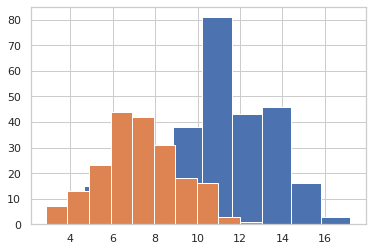

In [101]:
alg_total['Majority Male'][alg_total['Majority Male'].sex == 'Female'].effort.hist()
alg_total['Majority Male'][alg_total['Majority Male'].sex == 'Male'].effort.hist()

### Get mean differences and KL-divergences

This function outputs the disparities in sex for every algorithm given a specific qualification score interval.


In [131]:
def kl(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    return np.abs(np.sum(np.where(p != 0, p * np.log(p / (q+0.001)), 0)))

def get_histograms2(qs):
    cols = list(alg_total['Random Forest'].columns)

    sexes = alg_total['Random'].sex.unique()
    races =  alg_total['Random'].race.unique()
    bins = np.linspace(-5, 30, 10)

    histograms = {
        'Random':{q:{sex: np.zeros((19), float) for sex in sexes} for q in qs.keys()}, 
        'Decision Tree':{q:{sex: np.zeros((19), float) for sex in sexes} for q in qs.keys()}, 
        'Random Forest':{q:{sex: np.zeros((19), float) for sex in sexes} for q in qs.keys()}, 
        'Adaboost':{q:{sex: np.zeros((19), float) for sex in sexes} for q in qs.keys()}, 
        'SVM':{q:{sex: np.zeros((19), float) for sex in sexes} for q in qs.keys()}, 
        'Neural Net':{q:{sex: np.zeros((19), float) for sex in sexes} for q in qs.keys()}, 
        'K-Nearest Neighbor':{q:{sex: np.zeros((19), float) for sex in sexes} for q in qs.keys()}, 
        'Majority Male':{q:{sex: np.zeros((19), float) for sex in sexes} for q in qs.keys()}}

    alg_total_plot = pd.DataFrame(columns = cols).reset_index(drop=True)

    for i,name in enumerate(algnames1):

        alg_total[name] = alg_total[name][(alg_total[name].effort != '-')]
        alg_total[name].effort=alg_total[name].effort.astype(float)
        alg_total[name]['algname'] = name
        alg_total[name]['qualification'] = alg_total[name]['qualification'].astype(float)
        alg_total[name] = alg_total[name][~np.isnan(alg_total[name]['qualification'])]
        
        print("------")
        print("Alg: ", name)
        for q, (q1, q2) in zip(qs.keys(), qs.values()):
            for sex in sexes:

                a = alg_total[name].loc[(alg_total[name].sex==sex) & (alg_total[name]['qualification'] >= q1) & (alg_total[name]['qualification'] < q2)]

                print("Sex: ", sex)
                print("Mean: ", a['effort'].mean())
                a = a.effort
                a = a[~np.isnan(a)]

                histograms[name][q][sex] = [np.count_nonzero((a >= bins[ind]) & ((a < bins[ind+1]))) for ind in range(0, 9)]
                histograms[name][q][sex] /= np.sum(histograms[name][q][sex])


    kl_dict = {name:{q: 0 for q in qs} for name in algnames1}
    for i,name in enumerate(histograms.keys()):
        for q in qs.keys():
            pm = histograms[name][q][sexes[0]]
            pf = histograms[name][q][sexes[1]]
            if (pm != 0).any() and (pf != 0).any():
                kl_dict[name][q] = kl(pm, pf) + kl(pf, pm)
            else: 
                    print("_______________")
                    print(sex)
                    print(name)
                    print(" is not calculated")

    return histograms, kl_dict

# s, s2= get_histograms2({"q 6-20":(6, 20)})
# s2

### Function for plotting distributions

This function plots the effort distrbutions for every algorithm given specific qualification intervals.

In [132]:
def create_plot(histograms, fig, qn, verbose):
    
    algnames =  ['Random', 'Decision Tree', 'Random Forest', 'Adaboost', 'Neural Net', 'SVM', 'K-Nearest Neighbor', 'Majority Male']

    blues = cm.get_cmap('Blues')
    reds = cm.get_cmap('Reds')

    blues = blues(np.linspace(0.4, 0.65, len(algnames)))
    reds = reds(np.linspace(0.4, 0.65, len(algnames)))
    
    bins = np.linspace(-5, 30, 10)

    gs = grid_spec.GridSpec(len(algnames),1)

    ax_objs = []
    i = 0
    for name in algnames1:
        for ind, sex in enumerate(['Female', 'Male']):
            # creating new axes object
            ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

            # Smoothen distribution
            X_Y_Spline = make_interp_spline(bins[:-1], np.nan_to_num(histograms[name][sex]))

            # Returns evenly spaced numbers
            # over a specified interval.
            
            
            x = np.linspace(bins[:-1].min(), bins[:-1].max(), 500)
            y = X_Y_Spline(x)

            # plotting the distribution
            ax_objs[-1].plot(x, y ,color="#f0f0f0",lw=1)
            ax_objs[-1].fill_between(x,  y, color=blues[i] if sex == 'Male' else reds[i], alpha=0.7)

            # setting uniform x and y lims
            ax_objs[-1].set_xlim(-3.5,25)
            ax_objs[-1].set_ylim(0,0.6)
            ax_objs[-1].grid(False)

            # make background transparent
            rect = ax_objs[-1].patch
            rect.set_alpha(0)

            # remove borders, axis ticks, and labels
            ax_objs[-1].set_yticklabels([])
            plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False,
            ) # labels along the bottom edge are off

            if i == len(algnames)-1:
                ax_objs[-1].set_xlabel("Effort", fontsize=14,fontweight="bold")
            else:
                ax_objs[-1].set_xticklabels([])

                plt.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off

            spines = ["top","right","left","bottom"]
            for s in spines:
                ax_objs[-1].spines[s].set_visible(False)
            
            if verbose == True:
                ax_objs[-1].text(-4,0.008,name,fontweight="bold",fontsize=14,ha="right")

        if i == 0:
            # Title 
            plt.title(qn, fontweight="bold",fontsize=16,ha="right")
        if i == 0 and verbose == True:
            legend_elements = [Patch(facecolor=reds[3], edgecolor="#f0f0f0",
                                     label='Female'),
                               Patch(facecolor= blues[3], edgecolor="#f0f0f0",
                                     label='Male')]
            ax_objs[-1].legend(handles=legend_elements, loc='right')
        i += 1

    gs.update(hspace=0.3)
    

### Function for plotting KL-divergences

This function plots bar-plot of the KL-divergences for all algorithms given qualification intervals.

In [137]:

def NestedDictValues(d):
  for v in d.values():
    if isinstance(v, dict):
      yield from NestedDictValues(v)
    else:
      yield v

    
def colors_from_values(values, kl_dict, palette_name, mini = 0, maxi = 1):
    # normalize the values to range [0, 1]
    normalized = (values - 0) / (maxi - mini) 
    normalized = np.nan_to_num(normalized)

    normalized = [min(n, 1) for n in normalized]

    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)




def klplots(kl_dict, fig):
    
    algnames =  ['Random', 'Decision Tree', 'Random Forest', 'Adaboost', 'Neural Net', 'SVM', 'K-Nearest Neighbor', 'Majority Male']

    gs = grid_spec.GridSpec(len(algnames),1)

    ax_objs = []
    i = 0
    for name in algnames1:
            # creating new axes object
            ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
            
            df = pd.DataFrame([], columns = ['x', 'y'])
            df['x']  = kl_dict[name].keys()
            df['y'] = np.nan_to_num(kl_dict[name].values())
            sns.set_theme(style="whitegrid")
            
            palette = colors_from_values(df['y'], kl_dict, "YlOrRd", mini=0, maxi=3)
            
            ax = sns.barplot(x="x", y='y', data=df, palette=palette, alpha=0.9, ax=ax_objs[-1])
            ax_objs[-1].bar_label(ax.containers[0], fmt='%.2f')
            ax_objs[-1].grid(False)
            ax_objs[-1].set(xlabel=None, ylabel=None, yticklabels=[])
            ax_objs[-1].tick_params(left=False, bottom=False)
            plt.setp(ax.collections, alpha=.7)
            ax_objs[-1].set_ylim([0, 2])
            # make background transparent
            rect = ax_objs[-1].patch
            rect.set_alpha(0)

            ax_objs[-1].spines['top'].set_visible(False)
            ax_objs[-1].spines['right'].set_visible(False)
            ax_objs[-1].spines['bottom'].set_visible(True)
            ax_objs[-1].spines['left'].set_visible(False)
            
            if i == 0:
                ax_objs[-1].set_title("Symmetric KL-divergence", fontsize=16,fontweight="bold")
            if i == len(algnames)-1:
                ax_objs[-1].set_xlabel("Qualification Groups", fontsize=14,fontweight="bold")
                # ax_objs[-1].set_ylim([0, 20])
            else:
                ax_objs[-1].set_xticklabels([])
                plt.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off

            i+=1
    gs.update(hspace=0.3)
  
# h, k = get_histograms2({"q1":(0, 20), "q2":(20, 40)})
# f = plt.figure(figsize=(30, 10))
# klplots(k, f)
# plt.show()

### Plot everything together

This experiment plots and shows the auditing the fairness of every algorithm. It finds disparities between males and fmales of qualification invervals \[0, 40\] (meaning all of the population) and \[13, 24\] (meaning moderately qualified samples in the population). In the output, the mean values for each configuration are reported, the effort distributions are plotted for visual interpretation, and the symmetric KL-divergences are also derived. 

------
Alg:  Random Forest
Sex:  Female
Mean:  5.965177845719331
Sex:  Male
Mean:  6.001860521469151
------
Alg:  Decision Tree
Sex:  Female
Mean:  5.679681783046635
Sex:  Male
Mean:  5.067822331979913
------
Alg:  K-Nearest Neighbor
Sex:  Female
Mean:  6.8668694251413775
Sex:  Male
Mean:  4.84840193074235
------
Alg:  Neural Net
Sex:  Female
Mean:  5.81607856804257
Sex:  Male
Mean:  8.663967649729033
------
Alg:  SVM
Sex:  Female
Mean:  5.129519369799892
Sex:  Male
Mean:  6.211279645619402
------
Alg:  Adaboost
Sex:  Female
Mean:  9.335317014695752
Sex:  Male
Mean:  7.0754677232000445
------
Alg:  Random
Sex:  Female
Mean:  3.2070209529805433
Sex:  Male
Mean:  3.2194137347174467
------
Alg:  Majority Male
Sex:  Female
Mean:  10.567102008379937
Sex:  Male
Mean:  7.311792108789315


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/

<Figure size 360x1080 with 0 Axes>

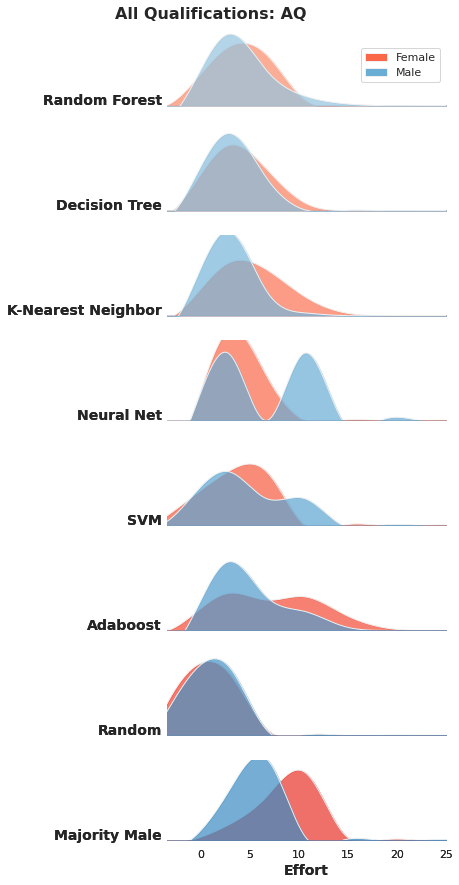

------
Alg:  Random Forest
Sex:  Female
Mean:  5.055534357752579
Sex:  Male
Mean:  5.699481611199227
------
Alg:  Decision Tree
Sex:  Female
Mean:  4.429650797986343
Sex:  Male
Mean:  4.5500699930434525
------
Alg:  K-Nearest Neighbor
Sex:  Female
Mean:  5.258421905666073
Sex:  Male
Mean:  4.71796453729576
------
Alg:  Neural Net
Sex:  Female
Mean:  5.81607856804257
Sex:  Male
Mean:  5.144156873019564
------
Alg:  SVM
Sex:  Female
Mean:  6.082767391186786
Sex:  Male
Mean:  5.868019068822332
------
Alg:  Adaboost
Sex:  Female
Mean:  8.339615096663907
Sex:  Male
Mean:  7.451217026187085
------
Alg:  Random
Sex:  Female
Mean:  2.8408530165859496
Sex:  Male
Mean:  3.1836264828604213
------
Alg:  Majority Male
Sex:  Female
Mean:  8.16455088960949
Sex:  Male
Mean:  5.651753792318009


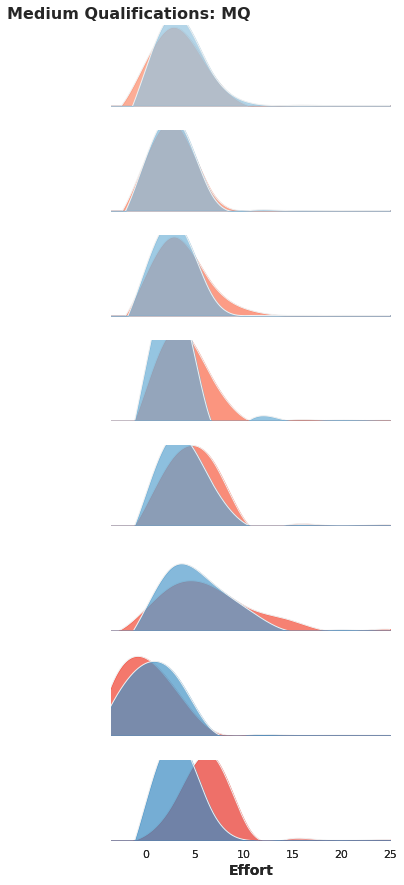

------
Alg:  Random Forest
Sex:  Female
Mean:  5.965177845719331
Sex:  Male
Mean:  6.001860521469151
Sex:  Female
Mean:  5.055534357752579
Sex:  Male
Mean:  5.699481611199227
------
Alg:  Decision Tree
Sex:  Female
Mean:  5.679681783046635
Sex:  Male
Mean:  5.067822331979913
Sex:  Female
Mean:  4.429650797986343
Sex:  Male
Mean:  4.5500699930434525
------
Alg:  K-Nearest Neighbor
Sex:  Female
Mean:  6.8668694251413775
Sex:  Male
Mean:  4.84840193074235
Sex:  Female
Mean:  5.258421905666073
Sex:  Male
Mean:  4.71796453729576
------
Alg:  Neural Net
Sex:  Female
Mean:  5.81607856804257
Sex:  Male
Mean:  8.663967649729033
Sex:  Female
Mean:  5.81607856804257
Sex:  Male
Mean:  5.144156873019564
------
Alg:  SVM
Sex:  Female
Mean:  5.129519369799892
Sex:  Male
Mean:  6.211279645619402
Sex:  Female
Mean:  6.082767391186786
Sex:  Male
Mean:  5.868019068822332
------
Alg:  Adaboost
Sex:  Female
Mean:  9.335317014695752
Sex:  Male
Mean:  7.0754677232000445
Sex:  Female
Mean:  8.339615096663907


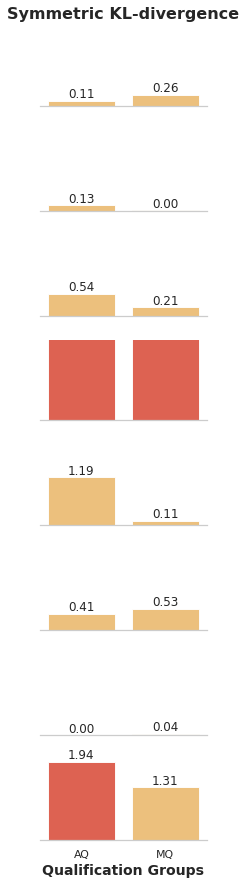

In [138]:

quals = [(0, 40), (13, 24)]
qual_names = ['All Qualifications: AQ', 'Medium Qualifications: MQ']


f = plt.figure(figsize=(5, 15))
subfigs = f.subfigures(1,5, width_ratios=[2, 2, 2, 2, 1], wspace=1)

for i, (qn, (q1, q2)) in enumerate(zip(qual_names,quals)):
    f = plt.figure(figsize=(5, 15))
    
    histograms, _ = get_histograms2({"tmp" :(q1, q2)})
    histograms = {h: histograms[h]['tmp'] for h in histograms.keys()}
    create_plot(histograms, f, qn, verbose=True if i == 0 else False)

    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('sexqual{}.png'.format(i), bbox_inches="tight")
    plt.show()

_, kl_dict = get_histograms2({"AQ":(0, 40), "MQ":(13, 24)})

 
f = plt.figure(figsize=(3, 15))
klplots(kl_dict, f)

print(kl_dict)

plt.savefig('sexqualkl.png', bbox_inches="tight")
plt.show()